In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Load the data**

In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\Paper Codes\Private_otclean\data\Adult_original\original_data\encoded_data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

14.96640866539207
-1.875329355539838
-1.824067966864841e-17
-0.2528321209681277
1.0


In [6]:
print(ground_truth_numpy)

[[-1.51784803 -1.87532936 -1.46414219 ... -0.16442018 -0.59634337
  -0.25422162]
 [-1.45352796 -1.06408074 -1.46401837 ... -0.16442018 -0.51774285
  -0.25422162]
 [-1.38920789 -0.25283212 -1.46389456 ... -0.16442018 -0.59634337
  -0.25422162]
 ...
 [-1.38920789 -0.25283212  0.39405744 ... -0.16442018 -0.28194128
  -0.25422162]
 [ 0.34743399 -0.25283212 -0.91638931 ... -0.16442018 -0.59634337
  -0.25422162]
 [-0.36008678  2.99216235  1.68531304 ... -0.16442018  0.03246082
  -0.25422162]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(48842, 13)
tensor(0)


**Creating missing values**

In [8]:

#10% MCAR

np.random.seed(42)

p_macr10 = 0.10


mask_mcar10 = np.random.rand(*ground_truth.shape) < p_macr10  # True for missing values, false for others
data_mcar10 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar10[mask_mcar10] = np.nan

# Convert to a torch tensor
data_mcar10 = torch.from_numpy(data_mcar10)

# Calculate the percentage of missing values
missing_values_mcar10 = torch.isnan(data_mcar10)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar10 = torch.sum(missing_values_mcar10).item() / data_mcar10.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar10:.2f}%")


Percentage of missing values: 10.00%


In [9]:
#15% MCAR

np.random.seed(42)

p_macr15 = 0.15


mask_mcar15 = np.random.rand(*ground_truth.shape) < p_macr15  # True for missing values, false for others
data_mcar15 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar15[mask_mcar15] = np.nan

# Convert to a torch tensor
data_mcar15 = torch.from_numpy(data_mcar15)

# Calculate the percentage of missing values
missing_values_mcar15 = torch.isnan(data_mcar15)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar15 = torch.sum(missing_values_mcar15).item() / data_mcar15.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar15:.2f}%")

Percentage of missing values: 14.95%


In [10]:
#20% MCAR
np.random.seed(42)

p_macr20 = 0.20


mask_mcar20 = np.random.rand(*ground_truth.shape) < p_macr20  # True for missing values, false for others
data_mcar20 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar20[mask_mcar20] = np.nan

# Convert to a torch tensor
data_mcar20 = torch.from_numpy(data_mcar20)

# Calculate the percentage of missing values
missing_values_mcar20 = torch.isnan(data_mcar20)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar20 = torch.sum(missing_values_mcar20).item() / data_mcar20.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar20:.2f}%")

Percentage of missing values: 19.95%


In [11]:
#25% MCAR
np.random.seed(42)

p_macr25 = 0.25


mask_mcar25 = np.random.rand(*ground_truth.shape) < p_macr25  # True for missing values, false for others
data_mcar25 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar25[mask_mcar25] = np.nan

# Convert to a torch tensor
data_mcar25 = torch.from_numpy(data_mcar25)

# Calculate the percentage of missing values
missing_values_mcar25 = torch.isnan(data_mcar25)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar25 = torch.sum(missing_values_mcar25).item() / data_mcar25.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar25:.2f}%")

Percentage of missing values: 24.99%


In [12]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.30


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 29.96%


In [13]:
#35% MCAR
np.random.seed(42)

p_macr35 = 0.35


mask_mcar35 = np.random.rand(*ground_truth.shape) < p_macr35  # True for missing values, false for others
data_mcar35 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar35[mask_mcar35] = np.nan

# Convert to a torch tensor
data_mcar35 = torch.from_numpy(data_mcar35)

# Calculate the percentage of missing values
missing_values_mcar35 = torch.isnan(data_mcar35)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar35 = torch.sum(missing_values_mcar35).item() / data_mcar35.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar35:.2f}%")

Percentage of missing values: 35.00%


In [14]:
#40% MCAR
np.random.seed(42)

p_macr40 = 0.40


mask_mcar40 = np.random.rand(*ground_truth.shape) < p_macr40  # True for missing values, false for others
data_mcar40 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar40[mask_mcar40] = np.nan

# Convert to a torch tensor
data_mcar40 = torch.from_numpy(data_mcar40)

# Calculate the percentage of missing values
missing_values_mcar40 = torch.isnan(data_mcar40)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar40 = torch.sum(missing_values_mcar40).item() / data_mcar40.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar40:.2f}%")

Percentage of missing values: 39.99%


In [15]:
#45% MCAR
np.random.seed(42)

p_macr45 = 0.45


mask_mcar45 = np.random.rand(*ground_truth.shape) < p_macr45  # True for missing values, false for others
data_mcar45 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar45[mask_mcar45] = np.nan

# Convert to a torch tensor
data_mcar45 = torch.from_numpy(data_mcar45)

# Calculate the percentage of missing values
missing_values_mcar45 = torch.isnan(data_mcar45)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar45 = torch.sum(missing_values_mcar45).item() / data_mcar45.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar45:.2f}%")

Percentage of missing values: 44.94%


In [16]:
#50% MCAR
np.random.seed(42)

p_macr50 = 0.50


mask_mcar50 = np.random.rand(*ground_truth.shape) < p_macr50  # True for missing values, false for others
data_mcar50 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar50[mask_mcar50] = np.nan

# Convert to a torch tensor
data_mcar50 = torch.from_numpy(data_mcar50)

# Calculate the percentage of missing values
missing_values_mcar50 = torch.isnan(data_mcar50)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar50 = torch.sum(missing_values_mcar50).item() / data_mcar50.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar50:.2f}%")

Percentage of missing values: 49.97%


In [17]:
#60% MCAR
np.random.seed(42)

p_macr60 = 0.60


mask_mcar60 = np.random.rand(*ground_truth.shape) < p_macr60  # True for missing values, false for others
data_mcar60 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar60[mask_mcar60] = np.nan

# Convert to a torch tensor
data_mcar60 = torch.from_numpy(data_mcar60)

# Calculate the percentage of missing values
missing_values_mcar60 = torch.isnan(data_mcar60)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar60 = torch.sum(missing_values_mcar60).item() / data_mcar60.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar60:.2f}%")

Percentage of missing values: 59.98%


In [18]:
#70 MCAR
np.random.seed(42)

p_macr70 = 0.70


mask_mcar70 = np.random.rand(*ground_truth.shape) < p_macr70  # True for missing values, false for others
data_mcar70 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar70[mask_mcar70] = np.nan

# Convert to a torch tensor
data_mcar70 = torch.from_numpy(data_mcar70)

# Calculate the percentage of missing values
missing_values_mcar70 = torch.isnan(data_mcar70)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar70 = torch.sum(missing_values_mcar70).item() / data_mcar70.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar70:.2f}%")

Percentage of missing values: 70.03%


In [19]:
#80% MCAR
np.random.seed(42)

p_macr80 = 0.80


mask_mcar80 = np.random.rand(*ground_truth.shape) < p_macr80  # True for missing values, false for others
data_mcar80 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar80[mask_mcar80] = np.nan

# Convert to a torch tensor
data_mcar80 = torch.from_numpy(data_mcar80)

# Calculate the percentage of missing values
missing_values_mcar80 = torch.isnan(data_mcar80)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar80 = torch.sum(missing_values_mcar80).item() / data_mcar80.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar80:.2f}%")

Percentage of missing values: 80.02%


In [20]:
#90% MCAR
np.random.seed(42)

p_macr90 = 0.9


mask_mcar90 = np.random.rand(*ground_truth.shape) < p_macr90  # True for missing values, false for others
data_mcar90 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar90[mask_mcar90] = np.nan

# Convert to a torch tensor
data_mcar90 = torch.from_numpy(data_mcar90)

# Calculate the percentage of missing values
missing_values_mcar90 = torch.isnan(data_mcar90)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar90 = torch.sum(missing_values_mcar90).item() / data_mcar90.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar90:.2f}%")

Percentage of missing values: 90.03%


In [21]:
#95% MCAR
np.random.seed(42)

p_macr95 = 0.95


mask_mcar95 = np.random.rand(*ground_truth.shape) < p_macr95  # True for missing values, false for others
data_mcar95 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar95[mask_mcar95] = np.nan

# Convert to a torch tensor
data_mcar95 = torch.from_numpy(data_mcar95)

# Calculate the percentage of missing values
missing_values_mcar95 = torch.isnan(data_mcar95)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar95 = torch.sum(missing_values_mcar95).item() / data_mcar95.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar95:.2f}%")

Percentage of missing values: 94.99%


In [22]:
#%100 MCAR
np.random.seed(42)

p_macr100 = 1


mask_mcar100 = np.random.rand(*ground_truth.shape) < p_macr100  # True for missing values, false for others
data_mcar100 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar100[mask_mcar100] = np.nan

# Convert to a torch tensor
data_mcar100 = torch.from_numpy(data_mcar100)

# Calculate the percentage of missing values
missing_values_mcar100 = torch.isnan(data_mcar100)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar100 = torch.sum(missing_values_mcar100).item() / data_mcar100.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar100:.2f}%")

Percentage of missing values: 100.00%


In [23]:
data_mcar10_numpy = data_mcar10.detach().cpu().numpy()
data_mcar15_numpy = data_mcar15.detach().cpu().numpy()
data_mcar20_numpy = data_mcar20.detach().cpu().numpy()
data_mcar25_numpy = data_mcar25.detach().cpu().numpy()
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()
data_mcar35_numpy = data_mcar35.detach().cpu().numpy()
data_mcar40_numpy = data_mcar40.detach().cpu().numpy()
data_mcar45_numpy = data_mcar45.detach().cpu().numpy()
data_mcar50_numpy = data_mcar50.detach().cpu().numpy()
data_mcar60_numpy = data_mcar60.detach().cpu().numpy()
data_mcar70_numpy = data_mcar70.detach().cpu().numpy()
data_mcar80_numpy = data_mcar80.detach().cpu().numpy()
data_mcar90_numpy = data_mcar90.detach().cpu().numpy()
data_mcar95_numpy = data_mcar95.detach().cpu().numpy()

**10% MCAR**

In [24]:
n_mcar10, d_mcar10 = data_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(data_mcar10)
print(epsilon_mcar10)

0.4323323565865451


In [25]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=2000)

In [26]:
sk_imp_mcar10, sk_maes10mcar, sk_rmses10mcar = sk_imputer_mcar10.fit_transform(data_mcar10, verbose=True, report_interval=500, X_true=ground_truth)

INFO:root:batchsize = 128, epsilon = 0.4323
INFO:root:Iteration 0:	 Loss: 4.0140	 Validation MAE: 0.6847	RMSE: 1.0006
INFO:root:Iteration 500:	 Loss: 3.0243	 Validation MAE: 0.6412	RMSE: 1.0038
INFO:root:Iteration 1000:	 Loss: 3.6621	 Validation MAE: 0.6184	RMSE: 1.0072
INFO:root:Iteration 1500:	 Loss: 3.2806	 Validation MAE: 0.6067	RMSE: 1.0120


In [27]:
#using numpy version of data
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()

In [28]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.6001140756851837 1.0157340250527946


In [29]:
#linear Round Robin
dmcar10_ = d_mcar10 - 1
models_liner_mcar10 = {}

for i in range(d_mcar10):
    models_liner_mcar10[i] = nn.Linear(dmcar10_, 1)

#Create the imputer
lin_rr_imputer_mcar10 = RRimputer(models_liner_mcar10, eps=epsilon_mcar10, lr=lr)
lin_rr_mcar10, lin_maesmcar10, lin_rmsesmcar10 = lin_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)
lin_rr_mcar10_numpy = lin_rr_mcar10.detach().cpu().numpy()

lin_rr_mae_mcar10 = MAE(lin_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
lin_rr_rmse_mcar10 = RMSE(lin_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(lin_rr_mae_mcar10,lin_rr_rmse_mcar10)

INFO:root:Iteration 0:	 Loss: 3.4656	Validation MAE: 0.7026	RMSE:  1.0277
INFO:root:Iteration 1:	 Loss: 3.3525	Validation MAE: 0.6323	RMSE:  0.9927
INFO:root:Iteration 2:	 Loss: 3.2239	Validation MAE: 0.6077	RMSE:  0.9945
INFO:root:Iteration 3:	 Loss: 3.2824	Validation MAE: 0.6014	RMSE:  0.9971
INFO:root:Iteration 4:	 Loss: 3.4231	Validation MAE: 0.5974	RMSE:  0.9989
INFO:root:Iteration 5:	 Loss: 3.4191	Validation MAE: 0.5978	RMSE:  1.0008
INFO:root:Iteration 6:	 Loss: 3.3867	Validation MAE: 0.5971	RMSE:  1.0002
INFO:root:Iteration 7:	 Loss: 3.3998	Validation MAE: 0.6014	RMSE:  1.0007
INFO:root:Iteration 8:	 Loss: 3.1592	Validation MAE: 0.6013	RMSE:  0.9984
INFO:root:Iteration 9:	 Loss: 3.3215	Validation MAE: 0.5994	RMSE:  0.9988
INFO:root:Early stopping criterion not reached


0.5993875881503248 0.9987949095120219


In [30]:
#MLP Round Robin
dmcar10_ = d_mcar10 - 1
models_mlp_mcar10 = {}


for i in range(d_mcar10):
   models_mlp_mcar10[i] = nn.Sequential(nn.Linear(dmcar10_, 2 * dmcar10_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar10_, dmcar10_),
                              nn.ReLU(),
                              nn.Linear(dmcar10_, 1))

#Create the imputer
mlp_rr_imputer_mcar10 = RRimputer(models_mlp_mcar10, eps=epsilon_mcar10, lr=lr)

mlp_rr_mcar10, mlp_rr_maesmcar10, mlp_rr_rmsesmcar10 = mlp_rr_imputer_mcar10.fit_transform(data_mcar10, verbose=True, X_true=ground_truth)

mlp_rr_mcar10_numpy = mlp_rr_mcar10.detach().cpu().numpy()

mlp_rr_mae_mcar10 = MAE(mlp_rr_mcar10_numpy,ground_truth_numpy ,mask_mcar10)
mlp_rr_rmse_mcar10 = RMSE(mlp_rr_mcar10_numpy, ground_truth_numpy,mask_mcar10)
print(mlp_rr_mae_mcar10,mlp_rr_rmse_mcar10)

INFO:root:Iteration 0:	 Loss: 3.4073	Validation MAE: 0.6142	RMSE:  1.0049
INFO:root:Iteration 1:	 Loss: 3.1878	Validation MAE: 0.6078	RMSE:  1.0075
INFO:root:Iteration 2:	 Loss: 3.2932	Validation MAE: 0.6010	RMSE:  1.0010
INFO:root:Iteration 3:	 Loss: 3.4193	Validation MAE: 0.5983	RMSE:  1.0065
INFO:root:Iteration 4:	 Loss: 3.3364	Validation MAE: 0.5974	RMSE:  0.9957
INFO:root:Iteration 5:	 Loss: 3.2964	Validation MAE: 0.5926	RMSE:  0.9964
INFO:root:Iteration 6:	 Loss: 3.4898	Validation MAE: 0.5964	RMSE:  0.9972
INFO:root:Iteration 7:	 Loss: 3.3827	Validation MAE: 0.5971	RMSE:  0.9964
INFO:root:Iteration 8:	 Loss: 3.4634	Validation MAE: 0.5894	RMSE:  0.9913
INFO:root:Iteration 9:	 Loss: 3.1338	Validation MAE: 0.5925	RMSE:  0.9991
INFO:root:Early stopping criterion not reached


0.592542315291802 0.9990631146095982


In [31]:
#mean
#using numpy version of data
mean_imp_mcar10 = SimpleImputer().fit_transform(data_mcar10_numpy)
mean_mae_mcar10 = MAE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.6816810692502873 0.9955999478093255


In [32]:
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar10_numpy)
ice_mae_mcar10 = MAE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.6524321269576117 0.9735210976589268


In [33]:
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(data_mcar10_numpy, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((data_mcar10_numpy), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, ground_truth_numpy, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.6637908946803982 0.9783766666817734


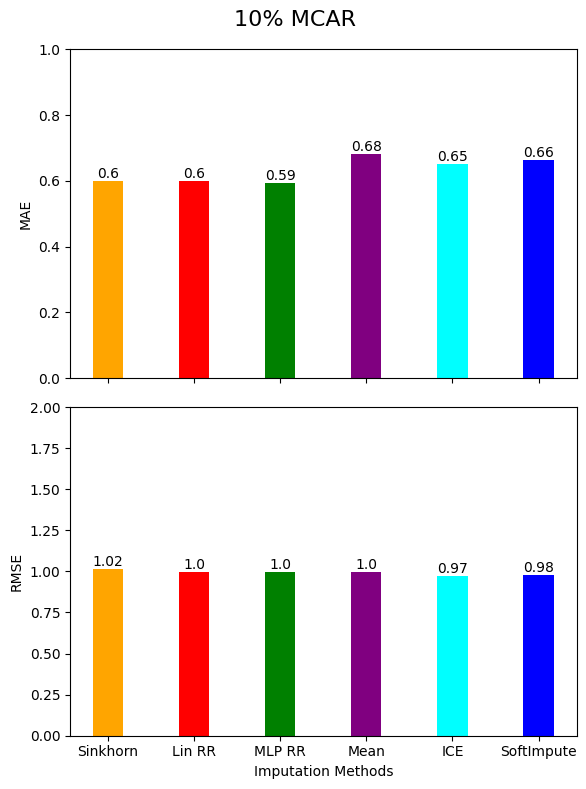

In [34]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


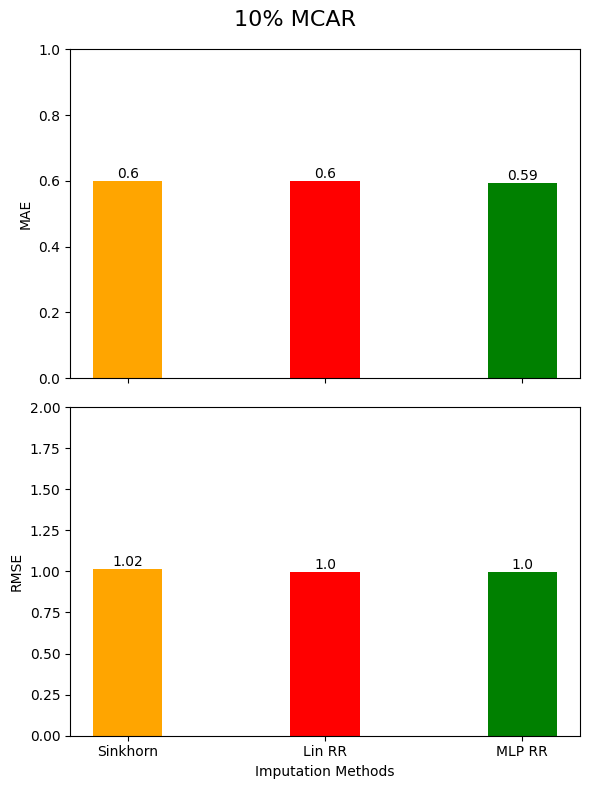

In [35]:

# Define values and categories
valuesOT_mae_mcar10 = [sk_mae_mcar10, lin_rr_mae_mcar10, mlp_rr_mae_mcar10]
valuesOT_rmse_mcar10 = [sk_rmse_mcar10,lin_rr_rmse_mcar10, mlp_rr_rmse_mcar10]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**15% MCAR**

In [36]:
#sinkhorn
n_mcar15, d_mcar15 = data_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(data_mcar15)

print(epsilon_mcar15)

sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes15mcar, sk_rmses15mcar = sk_imputer_mcar15.fit_transform(data_mcar15, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()

sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

INFO:root:batchsize = 128, epsilon = 0.4083


0.40830304187826383


INFO:root:Iteration 0:	 Loss: 2.8855	 Validation MAE: 0.6845	RMSE: 1.0019
INFO:root:Iteration 500:	 Loss: 3.3100	 Validation MAE: 0.6404	RMSE: 1.0045
INFO:root:Iteration 1000:	 Loss: 3.2334	 Validation MAE: 0.6180	RMSE: 1.0085
INFO:root:Iteration 1500:	 Loss: 3.4542	 Validation MAE: 0.6059	RMSE: 1.0124


0.59913555483658 1.016447562558919


In [37]:
#linear Round Robin
dmcar15_ = d_mcar15 - 1
models_liner_mcar15 = {}

for i in range(d_mcar15):
    models_liner_mcar15[i] = nn.Linear(dmcar15_, 1)

#Create the imputer
lin_rr_imputer_mcar15 = RRimputer(models_liner_mcar15, eps=epsilon_mcar15, lr=lr)
lin_rr_mcar15, lin_maesmcar15, lin_rmsesmcar15 = lin_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)
lin_rr_mcar15_numpy = lin_rr_mcar15.detach().cpu().numpy()

lin_rr_mae_mcar15 = MAE(lin_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
lin_rr_rmse_mcar15 = RMSE(lin_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(lin_rr_mae_mcar15,lin_rr_rmse_mcar15)

INFO:root:Iteration 0:	 Loss: 3.2393	Validation MAE: 0.6738	RMSE:  1.0231
INFO:root:Iteration 1:	 Loss: 3.2313	Validation MAE: 0.6109	RMSE:  0.9993
INFO:root:Iteration 2:	 Loss: 3.1469	Validation MAE: 0.5991	RMSE:  0.9987
INFO:root:Iteration 3:	 Loss: 3.3028	Validation MAE: 0.5990	RMSE:  0.9998
INFO:root:Iteration 4:	 Loss: 3.2022	Validation MAE: 0.5984	RMSE:  1.0027
INFO:root:Iteration 5:	 Loss: 3.2586	Validation MAE: 0.6012	RMSE:  1.0022
INFO:root:Iteration 6:	 Loss: 3.2363	Validation MAE: 0.5993	RMSE:  1.0003
INFO:root:Iteration 7:	 Loss: 3.1964	Validation MAE: 0.5978	RMSE:  1.0009
INFO:root:Iteration 8:	 Loss: 3.1539	Validation MAE: 0.5981	RMSE:  1.0004
INFO:root:Iteration 9:	 Loss: 3.3441	Validation MAE: 0.5983	RMSE:  0.9983
INFO:root:Early stopping criterion not reached


0.5983390904500524 0.9982763727652929


In [38]:
#MLP Round Robin
dmcar15_ = d_mcar15 - 1
models_mlp_mcar15 = {}


for i in range(d_mcar15):
   models_mlp_mcar15[i] = nn.Sequential(nn.Linear(dmcar15_, 2 * dmcar15_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar15_, dmcar15_),
                              nn.ReLU(),
                              nn.Linear(dmcar15_, 1))

#Create the imputer
mlp_rr_imputer_mcar15 = RRimputer(models_mlp_mcar15, eps=epsilon_mcar15, lr=lr)

mlp_rr_mcar15, mlp_rr_maesmcar15, mlp_rr_rmsesmcar15 = mlp_rr_imputer_mcar15.fit_transform(data_mcar15, verbose=True, X_true=ground_truth)

mlp_rr_mcar15_numpy = mlp_rr_mcar15.detach().cpu().numpy()

mlp_rr_mae_mcar15 = MAE(mlp_rr_mcar15_numpy,ground_truth_numpy ,mask_mcar15)
mlp_rr_rmse_mcar15 = RMSE(mlp_rr_mcar15_numpy, ground_truth_numpy,mask_mcar15)
print(mlp_rr_mae_mcar15,mlp_rr_rmse_mcar15)

INFO:root:Iteration 0:	 Loss: 3.3064	Validation MAE: 0.6078	RMSE:  1.0046
INFO:root:Iteration 1:	 Loss: 3.0512	Validation MAE: 0.6008	RMSE:  1.0043
INFO:root:Iteration 2:	 Loss: 3.0838	Validation MAE: 0.5997	RMSE:  1.0045
INFO:root:Iteration 3:	 Loss: 3.1531	Validation MAE: 0.5957	RMSE:  0.9986
INFO:root:Iteration 4:	 Loss: 3.2227	Validation MAE: 0.5950	RMSE:  1.0087
INFO:root:Iteration 5:	 Loss: 2.9150	Validation MAE: 0.5961	RMSE:  1.0020
INFO:root:Iteration 6:	 Loss: 3.2882	Validation MAE: 0.6008	RMSE:  1.0078
INFO:root:Iteration 7:	 Loss: 3.0298	Validation MAE: 0.5964	RMSE:  1.0011
INFO:root:Iteration 8:	 Loss: 3.0541	Validation MAE: 0.5963	RMSE:  1.0035
INFO:root:Iteration 9:	 Loss: 3.2538	Validation MAE: 0.5937	RMSE:  1.0014
INFO:root:Early stopping criterion not reached


0.5937107218261642 1.0013584931570259


In [39]:
#mean
#using numpy version of data
mean_imp_mcar15 = SimpleImputer().fit_transform(data_mcar15_numpy)
mean_mae_mcar15 = MAE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

#ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar15_numpy)
ice_mae_mcar15 = MAE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#SoftImpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(data_mcar15_numpy, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((data_mcar15_numpy), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, ground_truth_numpy, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)



0.6816208610659774 0.9969027085101955
0.6531359778395742 0.9766444895005371
0.6647189002493437 0.9806604175392343


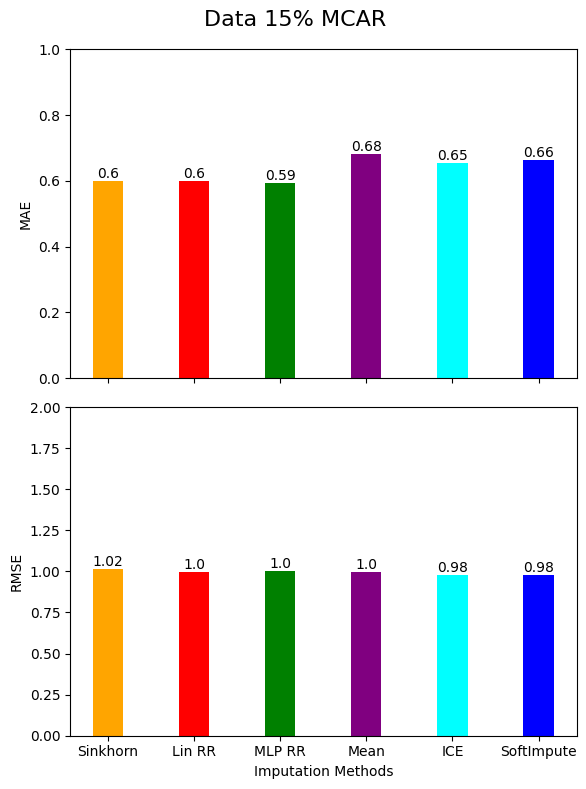

In [40]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


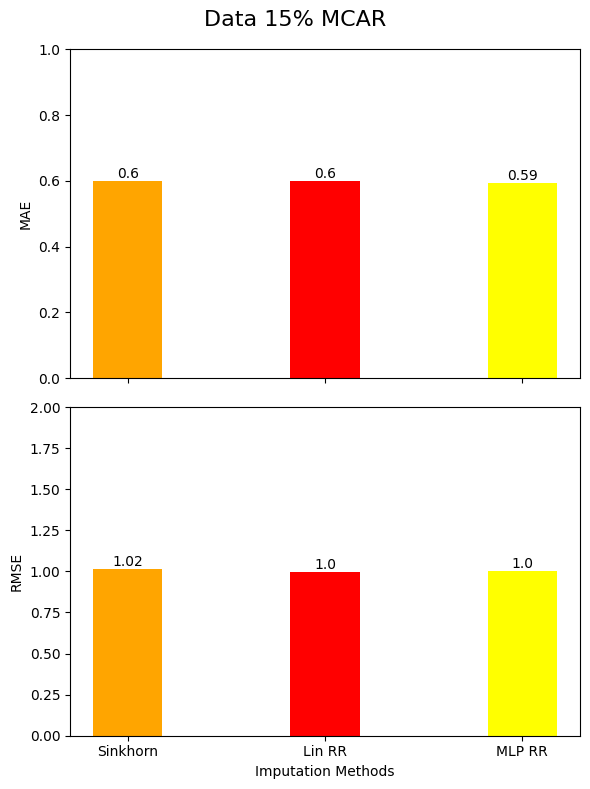

In [41]:

# Define values and categories
valuesOT_mae_mcar15 = [sk_mae_mcar15,lin_rr_mae_mcar15,mlp_rr_mae_mcar15]
valuesOT_rmse_mcar15 = [sk_rmse_mcar15,lin_rr_rmse_mcar15,mlp_rr_rmse_mcar15]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','yellow']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 15% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar15, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar15, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**20% MCAR**

In [42]:
#sinkhorn
n_mcar20, d_mcar20 = data_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(data_mcar20)

print(epsilon_mcar20)

sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes20mcar, sk_rmses20mcar = sk_imputer_mcar20.fit_transform(data_mcar20, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()

sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

INFO:root:batchsize = 128, epsilon = 0.3818


0.381845584749296


INFO:root:Iteration 0:	 Loss: 3.0136	 Validation MAE: 0.6845	RMSE: 1.0016
INFO:root:Iteration 500:	 Loss: 3.1954	 Validation MAE: 0.6425	RMSE: 1.0042
INFO:root:Iteration 1000:	 Loss: 3.0048	 Validation MAE: 0.6197	RMSE: 1.0085
INFO:root:Iteration 1500:	 Loss: 3.1131	 Validation MAE: 0.6070	RMSE: 1.0124


0.6002863934720665 1.0165551731732885


In [43]:
#linear Round Robin
dmcar20_ = d_mcar20 - 1
models_liner_mcar20 = {}

for i in range(d_mcar20):
    models_liner_mcar20[i] = nn.Linear(dmcar20_, 1)

#Create the imputer
lin_rr_imputer_mcar20 = RRimputer(models_liner_mcar20, eps=epsilon_mcar20, lr=lr)
lin_rr_mcar20, lin_maesmcar20, lin_rmsesmcar20 = lin_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)
lin_rr_mcar20_numpy = lin_rr_mcar20.detach().cpu().numpy()

lin_rr_mae_mcar20 = MAE(lin_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
lin_rr_rmse_mcar20 = RMSE(lin_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(lin_rr_mae_mcar20,lin_rr_rmse_mcar20)

INFO:root:Iteration 0:	 Loss: 3.4459	Validation MAE: 0.6821	RMSE:  1.0264
INFO:root:Iteration 1:	 Loss: 2.9557	Validation MAE: 0.6162	RMSE:  1.0026
INFO:root:Iteration 2:	 Loss: 2.9592	Validation MAE: 0.5994	RMSE:  1.0036
INFO:root:Iteration 3:	 Loss: 3.0847	Validation MAE: 0.5994	RMSE:  1.0028
INFO:root:Iteration 4:	 Loss: 3.2304	Validation MAE: 0.6026	RMSE:  0.9988
INFO:root:Iteration 5:	 Loss: 2.8712	Validation MAE: 0.6026	RMSE:  0.9992
INFO:root:Iteration 6:	 Loss: 2.8963	Validation MAE: 0.5987	RMSE:  1.0011
INFO:root:Iteration 7:	 Loss: 3.1293	Validation MAE: 0.5996	RMSE:  1.0027
INFO:root:Iteration 8:	 Loss: 3.0534	Validation MAE: 0.6051	RMSE:  1.0011
INFO:root:Iteration 9:	 Loss: 3.0845	Validation MAE: 0.6026	RMSE:  1.0012
INFO:root:Early stopping criterion not reached


0.6025996700298711 1.001231329974871


In [44]:
#MLP Round Robin
dmcar20_ = d_mcar20 - 1
models_mlp_mcar20 = {}


for i in range(d_mcar20):
   models_mlp_mcar20[i] = nn.Sequential(nn.Linear(dmcar20_, 2 * dmcar20_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar20_, dmcar20_),
                              nn.ReLU(),
                              nn.Linear(dmcar20_, 1))

#Create the imputer
mlp_rr_imputer_mcar20 = RRimputer(models_mlp_mcar20, eps=epsilon_mcar20, lr=lr)

mlp_rr_mcar20, mlp_rr_maesmcar20, mlp_rr_rmsesmcar20 = mlp_rr_imputer_mcar20.fit_transform(data_mcar20, verbose=True, X_true=ground_truth)

mlp_rr_mcar20_numpy = mlp_rr_mcar20.detach().cpu().numpy()

mlp_rr_mae_mcar20 = MAE(mlp_rr_mcar20_numpy,ground_truth_numpy ,mask_mcar20)
mlp_rr_rmse_mcar20 = RMSE(mlp_rr_mcar20_numpy, ground_truth_numpy,mask_mcar20)
print(mlp_rr_mae_mcar20,mlp_rr_rmse_mcar20)

INFO:root:Iteration 0:	 Loss: 2.9764	Validation MAE: 0.6129	RMSE:  1.0037
INFO:root:Iteration 1:	 Loss: 2.9694	Validation MAE: 0.5988	RMSE:  1.0037
INFO:root:Iteration 2:	 Loss: 2.9008	Validation MAE: 0.6013	RMSE:  0.9973
INFO:root:Iteration 3:	 Loss: 2.8984	Validation MAE: 0.5965	RMSE:  1.0001
INFO:root:Iteration 4:	 Loss: 3.2272	Validation MAE: 0.5945	RMSE:  1.0005
INFO:root:Iteration 5:	 Loss: 2.9151	Validation MAE: 0.6043	RMSE:  1.0048
INFO:root:Iteration 6:	 Loss: 3.0731	Validation MAE: 0.5947	RMSE:  1.0044
INFO:root:Iteration 7:	 Loss: 3.1193	Validation MAE: 0.5923	RMSE:  1.0027
INFO:root:Iteration 8:	 Loss: 2.7776	Validation MAE: 0.5912	RMSE:  1.0021
INFO:root:Iteration 9:	 Loss: 3.0972	Validation MAE: 0.5924	RMSE:  1.0025
INFO:root:Early stopping criterion not reached


0.5924101200962595 1.0025459176656943


In [45]:
#mean
#using numpy version of data
mean_imp_mcar20 = SimpleImputer().fit_transform(data_mcar20_numpy)
mean_mae_mcar20 = MAE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

#ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar20_numpy)
ice_mae_mcar20 = MAE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#SoftImpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(data_mcar20_numpy, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((data_mcar20_numpy), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, ground_truth_numpy, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.6814334874699427 0.9961840770908921
0.6550454879812564 0.9792479326775346
0.6658185786694094 0.9811914140564313


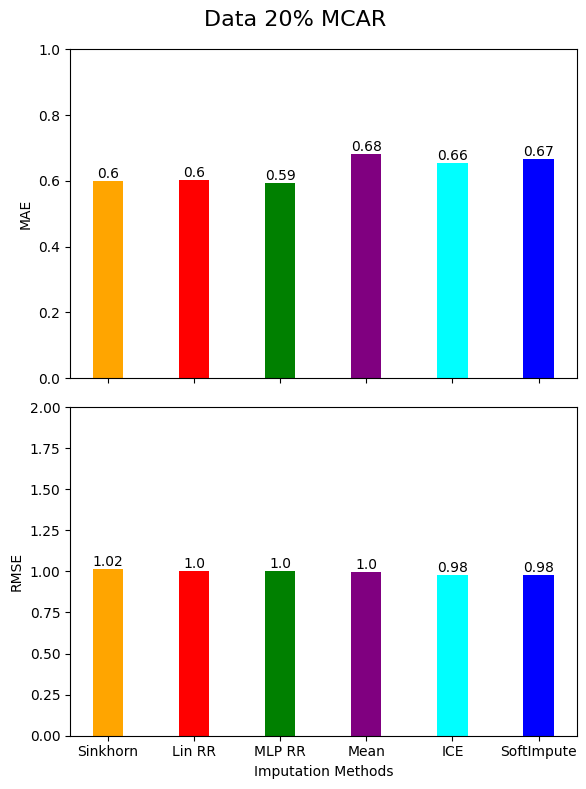

In [46]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


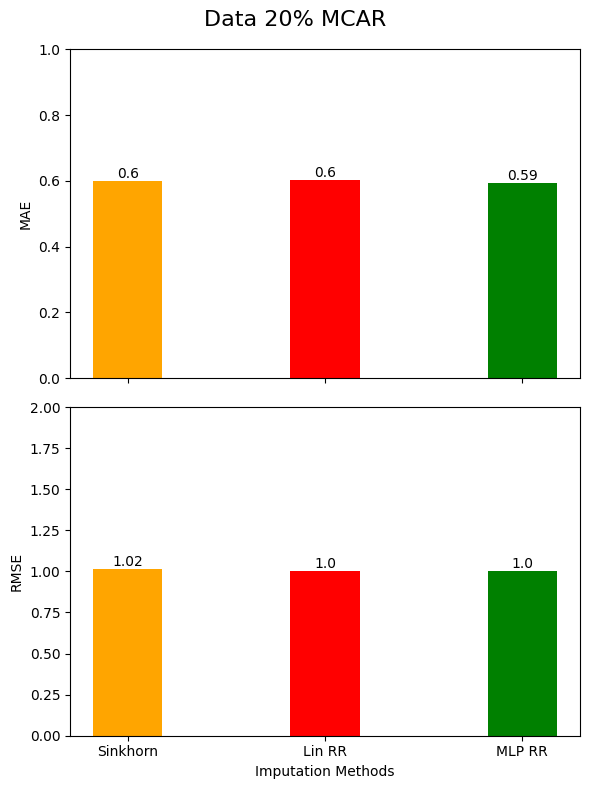

In [47]:

# Define values and categories
valuesOT_mae_mcar20 = [sk_mae_mcar20,lin_rr_mae_mcar20,mlp_rr_mae_mcar20]
valuesOT_rmse_mcar20 = [sk_rmse_mcar20,lin_rr_rmse_mcar20,mlp_rr_rmse_mcar20]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 20% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar20, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar20, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**25% MCAR**

In [48]:
#sinkhorn
n_mcar25, d_mcar25 = data_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(data_mcar25)

print(epsilon_mcar25)

sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar = sk_imputer_mcar25.fit_transform(data_mcar25, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,ground_truth_numpy,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

INFO:root:batchsize = 128, epsilon = 0.3606


0.3606186358513528


INFO:root:Iteration 0:	 Loss: 2.9286	 Validation MAE: 0.6826	RMSE: 0.9977
INFO:root:Iteration 500:	 Loss: 2.6955	 Validation MAE: 0.6413	RMSE: 1.0006
INFO:root:Iteration 1000:	 Loss: 2.6004	 Validation MAE: 0.6183	RMSE: 1.0041
INFO:root:Iteration 1500:	 Loss: 2.9751	 Validation MAE: 0.6056	RMSE: 1.0080


0.5985728681056071 1.0123345044952359


In [49]:
#linear Round Robin
dmcar25_ = d_mcar25 - 1
models_liner_mcar25 = {}

for i in range(d_mcar25):
    models_liner_mcar25[i] = nn.Linear(dmcar25_, 1)

#Create the imputer
lin_rr_imputer_mcar25 = RRimputer(models_liner_mcar25, eps=epsilon_mcar25, lr=lr)
lin_rr_mcar25, lin_maesmcar25, lin_rmsesmcar25 = lin_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)
lin_rr_mcar25_numpy = lin_rr_mcar25.detach().cpu().numpy()

lin_rr_mae_mcar25 = MAE(lin_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
lin_rr_rmse_mcar25 = RMSE(lin_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(lin_rr_mae_mcar25,lin_rr_rmse_mcar25)

INFO:root:Iteration 0:	 Loss: 2.8058	Validation MAE: 0.6745	RMSE:  1.0193
INFO:root:Iteration 1:	 Loss: 2.7992	Validation MAE: 0.6196	RMSE:  0.9966
INFO:root:Iteration 2:	 Loss: 2.7821	Validation MAE: 0.6081	RMSE:  0.9972
INFO:root:Iteration 3:	 Loss: 2.7074	Validation MAE: 0.6019	RMSE:  0.9975
INFO:root:Iteration 4:	 Loss: 3.0887	Validation MAE: 0.6004	RMSE:  0.9968
INFO:root:Iteration 5:	 Loss: 2.8893	Validation MAE: 0.6032	RMSE:  0.9959
INFO:root:Iteration 6:	 Loss: 2.8987	Validation MAE: 0.6030	RMSE:  0.9963
INFO:root:Iteration 7:	 Loss: 2.9852	Validation MAE: 0.6007	RMSE:  1.0001
INFO:root:Iteration 8:	 Loss: 3.0274	Validation MAE: 0.6021	RMSE:  1.0011
INFO:root:Iteration 9:	 Loss: 2.8681	Validation MAE: 0.6019	RMSE:  0.9996
INFO:root:Early stopping criterion not reached


0.6018616393533893 0.9995568889728162


In [50]:
#MLP Round Robin
dmcar25_ = d_mcar25 - 1
models_mlp_mcar25 = {}


for i in range(d_mcar25):
   models_mlp_mcar25[i] = nn.Sequential(nn.Linear(dmcar25_, 2 * dmcar25_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar25_, dmcar25_),
                              nn.ReLU(),
                              nn.Linear(dmcar25_, 1))

#Create the imputer
mlp_rr_imputer_mcar25 = RRimputer(models_mlp_mcar25, eps=epsilon_mcar25, lr=lr)

mlp_rr_mcar25, mlp_rr_maesmcar25, mlp_rr_rmsesmcar25 = mlp_rr_imputer_mcar25.fit_transform(data_mcar25, verbose=True, X_true=ground_truth)

mlp_rr_mcar25_numpy = mlp_rr_mcar25.detach().cpu().numpy()

mlp_rr_mae_mcar25 = MAE(mlp_rr_mcar25_numpy,ground_truth_numpy,mask_mcar25)
mlp_rr_rmse_mcar25 = RMSE(mlp_rr_mcar25_numpy, ground_truth_numpy,mask_mcar25)
print(mlp_rr_mae_mcar25,mlp_rr_rmse_mcar25)

INFO:root:Iteration 0:	 Loss: 2.9363	Validation MAE: 0.6081	RMSE:  1.0007
INFO:root:Iteration 1:	 Loss: 2.7160	Validation MAE: 0.6022	RMSE:  1.0009
INFO:root:Iteration 2:	 Loss: 2.7554	Validation MAE: 0.6031	RMSE:  0.9995
INFO:root:Iteration 3:	 Loss: 2.8419	Validation MAE: 0.5944	RMSE:  0.9996
INFO:root:Iteration 4:	 Loss: 3.0594	Validation MAE: 0.6051	RMSE:  1.0007
INFO:root:Iteration 5:	 Loss: 2.8224	Validation MAE: 0.6027	RMSE:  1.0015
INFO:root:Iteration 6:	 Loss: 2.8203	Validation MAE: 0.5970	RMSE:  0.9977
INFO:root:Iteration 7:	 Loss: 2.9207	Validation MAE: 0.5951	RMSE:  1.0073
INFO:root:Iteration 8:	 Loss: 2.8665	Validation MAE: 0.5955	RMSE:  1.0065
INFO:root:Iteration 9:	 Loss: 2.9678	Validation MAE: 0.5949	RMSE:  1.0066
INFO:root:Early stopping criterion not reached


0.5948554205654853 1.0065887966639298


In [51]:
#mean
#using numpy version of data
mean_imp_mcar25 = SimpleImputer().fit_transform(data_mcar25_numpy)
mean_mae_mcar25 = MAE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

#ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar25_numpy)
ice_mae_mcar25 = MAE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#SoftImpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(data_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((data_mcar25_numpy), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, ground_truth_numpy, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.6800724149875478 0.9928754317189004
0.655618503005938 0.9793617899531554
0.6651385934241437 0.9786950676320304


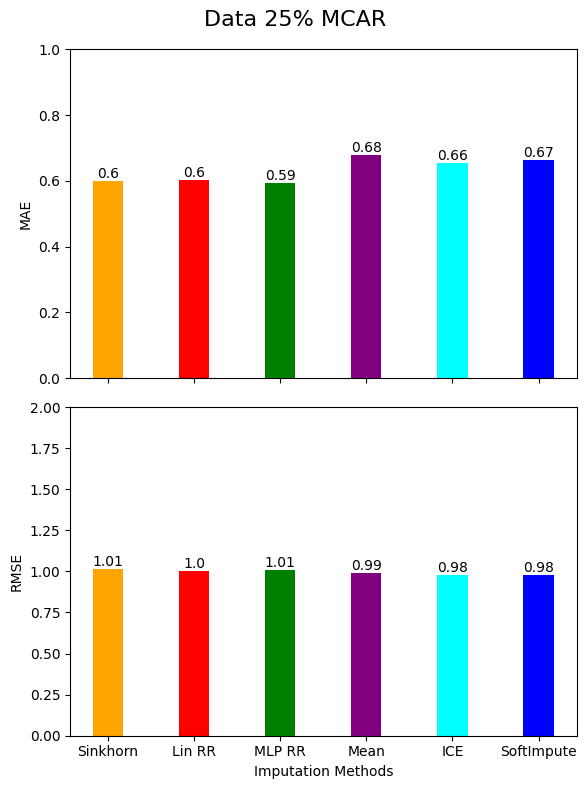

In [52]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


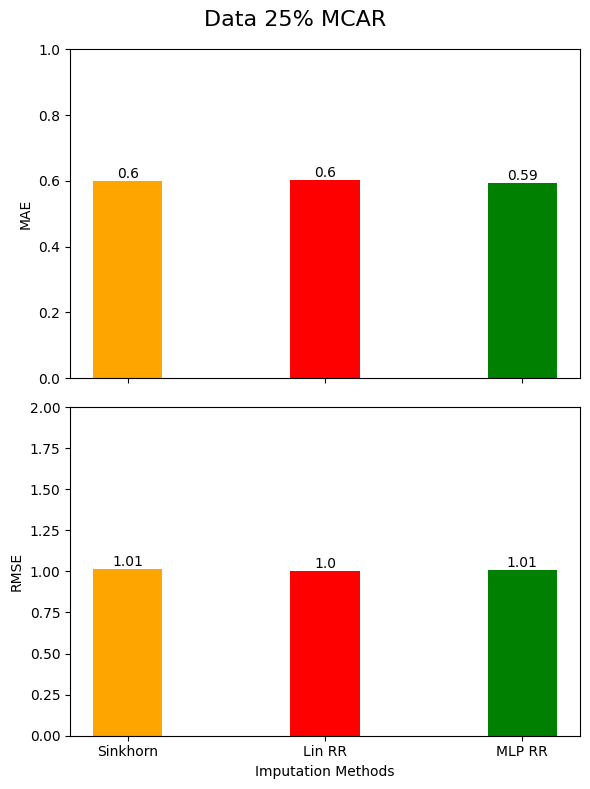

In [53]:

# Define values and categories
valuesOT_mae_mcar25 = [sk_mae_mcar25,lin_rr_mae_mcar25,mlp_rr_mae_mcar25]
valuesOT_rmse_mcar25 = [sk_rmse_mcar25,lin_rr_rmse_mcar25,mlp_rr_rmse_mcar25]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**30% MCAR**

In [54]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(data_mcar30)
print(epsilon_mcar30)

sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:batchsize = 128, epsilon = 0.3338


0.33379610275631766


INFO:root:Iteration 0:	 Loss: 2.7052	 Validation MAE: 0.6840	RMSE: 1.0001
INFO:root:Iteration 500:	 Loss: 3.0895	 Validation MAE: 0.6440	RMSE: 1.0026
INFO:root:Iteration 1000:	 Loss: 2.3250	 Validation MAE: 0.6208	RMSE: 1.0064
INFO:root:Iteration 1500:	 Loss: 2.6525	 Validation MAE: 0.6079	RMSE: 1.0104


0.6003880976257042 1.0146359743441031


In [55]:
#linear Round Robin
dmcar30_ = d_mcar30 - 1
models_liner_mcar30 = {}

for i in range(d_mcar30):
    models_liner_mcar30[i] = nn.Linear(dmcar30_, 1)

#Create the imputer
lin_rr_imputer_mcar30 = RRimputer(models_liner_mcar30, eps=epsilon_mcar30, lr=lr)
lin_rr_mcar30, lin_maesmcar30, lin_rmsesmcar30 = lin_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)
lin_rr_mcar30_numpy = lin_rr_mcar30.detach().cpu().numpy()

lin_rr_mae_mcar30 = MAE(lin_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
lin_rr_rmse_mcar30 = RMSE(lin_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(lin_rr_mae_mcar30,lin_rr_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 3.1089	Validation MAE: 0.6665	RMSE:  1.0160
INFO:root:Iteration 1:	 Loss: 2.7780	Validation MAE: 0.6194	RMSE:  0.9980
INFO:root:Iteration 2:	 Loss: 3.0232	Validation MAE: 0.6095	RMSE:  0.9987
INFO:root:Iteration 3:	 Loss: 2.8080	Validation MAE: 0.6050	RMSE:  0.9996
INFO:root:Iteration 4:	 Loss: 2.6873	Validation MAE: 0.6060	RMSE:  0.9992
INFO:root:Iteration 5:	 Loss: 2.6035	Validation MAE: 0.6062	RMSE:  0.9986
INFO:root:Iteration 6:	 Loss: 2.8842	Validation MAE: 0.6062	RMSE:  1.0002
INFO:root:Iteration 7:	 Loss: 2.6919	Validation MAE: 0.6059	RMSE:  1.0021
INFO:root:Iteration 8:	 Loss: 2.6991	Validation MAE: 0.6075	RMSE:  1.0020
INFO:root:Iteration 9:	 Loss: 2.6818	Validation MAE: 0.6064	RMSE:  1.0013
INFO:root:Early stopping criterion not reached


0.6063916540094334 1.0013182468938602


In [56]:
#MLP Round Robin
dmcar30_ = d_mcar30 - 1
models_mlp_mcar30 = {}


for i in range(d_mcar30):
   models_mlp_mcar30[i] = nn.Sequential(nn.Linear(dmcar30_, 2 * dmcar30_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar30_, dmcar30_),
                              nn.ReLU(),
                              nn.Linear(dmcar30_, 1))

#Create the imputer
mlp_rr_imputer_mcar30 = RRimputer(models_mlp_mcar30, eps=epsilon_mcar30, lr=lr)

mlp_rr_mcar30, mlp_rr_maesmcar30, mlp_rr_rmsesmcar30 = mlp_rr_imputer_mcar30.fit_transform(data_mcar30, verbose=True, X_true=ground_truth)

mlp_rr_mcar30_numpy = mlp_rr_mcar30.detach().cpu().numpy()

mlp_rr_mae_mcar30 = MAE(mlp_rr_mcar30_numpy,ground_truth_numpy,mask_mcar30)
mlp_rr_rmse_mcar30 = RMSE(mlp_rr_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(mlp_rr_mae_mcar30, mlp_rr_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 2.8559	Validation MAE: 0.6109	RMSE:  1.0121
INFO:root:Iteration 1:	 Loss: 2.7858	Validation MAE: 0.6043	RMSE:  0.9992
INFO:root:Iteration 2:	 Loss: 2.5532	Validation MAE: 0.6037	RMSE:  1.0077
INFO:root:Iteration 3:	 Loss: 2.8969	Validation MAE: 0.5994	RMSE:  1.0076
INFO:root:Iteration 4:	 Loss: 2.8442	Validation MAE: 0.5978	RMSE:  1.0048
INFO:root:Iteration 5:	 Loss: 2.6177	Validation MAE: 0.6030	RMSE:  1.0085
INFO:root:Iteration 6:	 Loss: 2.7464	Validation MAE: 0.6041	RMSE:  1.0122
INFO:root:Iteration 7:	 Loss: 2.7931	Validation MAE: 0.5957	RMSE:  1.0121
INFO:root:Iteration 8:	 Loss: 2.5760	Validation MAE: 0.6044	RMSE:  1.0201
INFO:root:Iteration 9:	 Loss: 2.7574	Validation MAE: 0.6064	RMSE:  1.0255
INFO:root:Early stopping criterion not reached


0.6063925311389177 1.0255025540586042


In [57]:
#mean
#using numpy version of data
mean_imp_mcar30 = SimpleImputer().fit_transform(data_mcar30_numpy)
mean_mae_mcar30 = MAE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
mean_rmse_mcar30= RMSE(mean_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

#ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar30_numpy)
ice_mae_mcar30 = MAE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(ice_mae_mcar30,ice_rmse_mcar30)

#SoftImpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(data_mcar30_numpy, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((data_mcar30_numpy), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, ground_truth_numpy, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.6811921111643477 0.9949474963555379
0.6612103213732621 0.9873865402791078
0.6673399263551435 0.9817223395502991


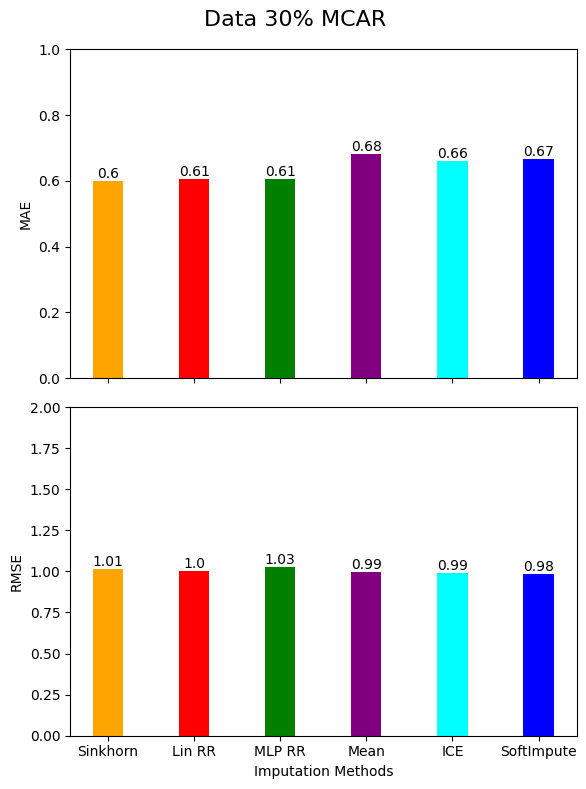

In [58]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


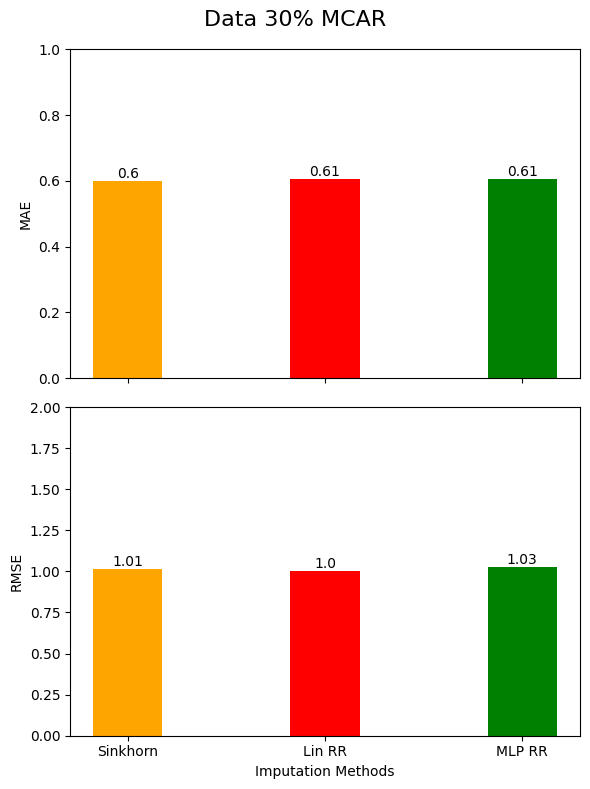

In [59]:

# Define values and categories
valuesOT_mae_mcar30 = [sk_mae_mcar30,lin_rr_mae_mcar30,mlp_rr_mae_mcar30]
valuesOT_rmse_mcar30 = [sk_rmse_mcar30,lin_rr_rmse_mcar30,mlp_rr_rmse_mcar30]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 30% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar30, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar30, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**35% MCAR**

In [60]:
#sinkhorn
n_mcar35, d_mcar35 = data_mcar35.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar35 = pick_epsilon(data_mcar35)

print(epsilon_mcar35)

sk_imputer_mcar35 = SinkhornImputation(eps=epsilon_mcar35, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar35, sk_maes35mcar, sk_rmses35mcar = sk_imputer_mcar35.fit_transform(data_mcar35, verbose=True, report_interval=500, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar35_numpy = sk_imp_mcar35.detach().cpu().numpy()

sk_mae_mcar35 = MAE(sk_imp_mcar35_numpy,ground_truth_numpy,mask_mcar35)
sk_rmse_mcar35 = RMSE(sk_imp_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(sk_mae_mcar35,sk_rmse_mcar35)

INFO:root:batchsize = 128, epsilon = 0.3012
INFO:root:Iteration 0:	 Loss: 2.4883	 Validation MAE: 0.6836	RMSE: 1.0015


0.30122743997244655


INFO:root:Iteration 500:	 Loss: 2.0263	 Validation MAE: 0.6452	RMSE: 1.0036
INFO:root:Iteration 1000:	 Loss: 2.3963	 Validation MAE: 0.6224	RMSE: 1.0072
INFO:root:Iteration 1500:	 Loss: 2.4661	 Validation MAE: 0.6091	RMSE: 1.0110


0.601381672974002 1.014807552994489


In [61]:
#linear Round Robin
dmcar35_ = d_mcar35 - 1
models_liner_mcar35 = {}

for i in range(d_mcar35):
    models_liner_mcar35[i] = nn.Linear(dmcar35_, 1)

#Create the imputer
lin_rr_imputer_mcar35 = RRimputer(models_liner_mcar35, eps=epsilon_mcar35, lr=lr)
lin_rr_mcar35, lin_maesmcar35, lin_rmsesmcar35 = lin_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)
lin_rr_mcar35_numpy = lin_rr_mcar35.detach().cpu().numpy()

lin_rr_mae_mcar35 = MAE(lin_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
lin_rr_rmse_mcar35 = RMSE(lin_rr_mcar35_numpy,ground_truth_numpy,mask_mcar35)
print(lin_rr_mae_mcar35,lin_rr_rmse_mcar35)

INFO:root:Iteration 0:	 Loss: 2.7848	Validation MAE: 0.6646	RMSE:  1.0230
INFO:root:Iteration 1:	 Loss: 2.6109	Validation MAE: 0.6200	RMSE:  1.0009
INFO:root:Iteration 2:	 Loss: 2.5260	Validation MAE: 0.6139	RMSE:  1.0031
INFO:root:Iteration 3:	 Loss: 2.4047	Validation MAE: 0.6106	RMSE:  1.0031
INFO:root:Iteration 4:	 Loss: 2.5340	Validation MAE: 0.6098	RMSE:  1.0012
INFO:root:Iteration 5:	 Loss: 2.5333	Validation MAE: 0.6092	RMSE:  1.0025
INFO:root:Iteration 6:	 Loss: 2.6834	Validation MAE: 0.6095	RMSE:  1.0036
INFO:root:Iteration 7:	 Loss: 2.6206	Validation MAE: 0.6103	RMSE:  1.0054
INFO:root:Iteration 8:	 Loss: 2.7740	Validation MAE: 0.6111	RMSE:  1.0076
INFO:root:Iteration 9:	 Loss: 2.8045	Validation MAE: 0.6106	RMSE:  1.0069
INFO:root:Early stopping criterion not reached


0.6105616196346816 1.0069201702490513


In [62]:
#MLP Round Robin
dmcar35_ = d_mcar35 - 1
models_mlp_mcar35 = {}


for i in range(d_mcar35):
   models_mlp_mcar35[i] = nn.Sequential(nn.Linear(dmcar35_, 2 * dmcar35_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar35_, dmcar35_),
                              nn.ReLU(),
                              nn.Linear(dmcar35_, 1))

#Create the imputer
mlp_rr_imputer_mcar35 = RRimputer(models_mlp_mcar35, eps=epsilon_mcar35, lr=lr)

mlp_rr_mcar35, mlp_rr_maesmcar35, mlp_rr_rmsesmcar35 = mlp_rr_imputer_mcar35.fit_transform(data_mcar35, verbose=True, X_true=ground_truth)

mlp_rr_mcar35_numpy = mlp_rr_mcar35.detach().cpu().numpy()

mlp_rr_mae_mcar35 = MAE(mlp_rr_mcar35_numpy,ground_truth_numpy ,mask_mcar35)
mlp_rr_rmse_mcar35 = RMSE(mlp_rr_mcar35_numpy, ground_truth_numpy,mask_mcar35)
print(mlp_rr_mae_mcar35, mlp_rr_rmse_mcar35)

INFO:root:Iteration 0:	 Loss: 2.7747	Validation MAE: 0.6152	RMSE:  1.0007
INFO:root:Iteration 1:	 Loss: 2.5098	Validation MAE: 0.6008	RMSE:  1.0011
INFO:root:Iteration 2:	 Loss: 2.6919	Validation MAE: 0.6060	RMSE:  1.0086
INFO:root:Iteration 3:	 Loss: 2.4302	Validation MAE: 0.6098	RMSE:  1.0204
INFO:root:Iteration 4:	 Loss: 2.7220	Validation MAE: 0.6079	RMSE:  1.0171
INFO:root:Iteration 5:	 Loss: 2.4855	Validation MAE: 0.6061	RMSE:  1.0238
INFO:root:Iteration 6:	 Loss: 2.5828	Validation MAE: 0.6096	RMSE:  1.0285
INFO:root:Iteration 7:	 Loss: 2.6608	Validation MAE: 0.6069	RMSE:  1.0297
INFO:root:Iteration 8:	 Loss: 2.5902	Validation MAE: 0.6113	RMSE:  1.0278
INFO:root:Iteration 9:	 Loss: 2.4516	Validation MAE: 0.6115	RMSE:  1.0328
INFO:root:Early stopping criterion not reached


0.6114690756920254 1.0328068489569289


In [63]:
#mean
#using numpy version of data
mean_imp_mcar35 = SimpleImputer().fit_transform(data_mcar35_numpy)
mean_mae_mcar35 = MAE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
mean_rmse_mcar35 = RMSE(mean_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(mean_mae_mcar35, mean_rmse_mcar35)

#ICE
ice_imp_mcar35 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar35_numpy)
ice_mae_mcar35 = MAE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
ice_rmse_mcar35 = RMSE(ice_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(ice_mae_mcar35,ice_rmse_mcar35)

#SoftImpute
cv_error_mcar35, grid_lambda_mcar35 = cv_softimpute(data_mcar35_numpy, grid_len=15)
lbda_mcar35 = grid_lambda_mcar35[np.argmin(cv_error_mcar35)]
soft_imp_mcar35 = softimpute((data_mcar35_numpy), lbda_mcar35)[1]

soft_mae_mcar35 = MAE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
soft_rmse_mcar35 = RMSE(soft_imp_mcar35, ground_truth_numpy, mask_mcar35)
print(soft_mae_mcar35,soft_rmse_mcar35)

0.681126809326389 0.9964540239874186
0.801279756844319 1.1551921505255696
0.6715328551640122 0.9869257113472943


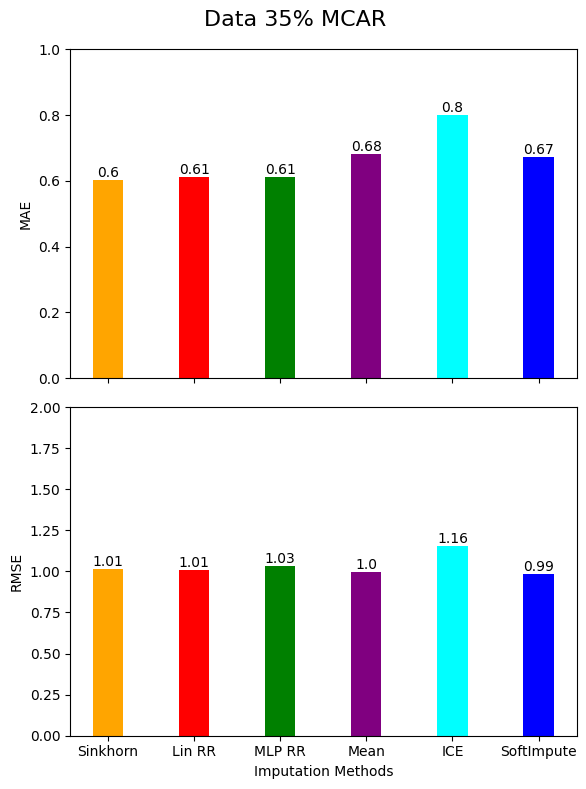

In [64]:

# Define values and categories
values_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35, mean_mae_mcar35, ice_mae_mcar35, soft_mae_mcar35]
values_rmse_mcar35 = [sk_rmse_mcar35, lin_rr_rmse_mcar35, mlp_rr_rmse_mcar35, mean_rmse_mcar35, ice_rmse_mcar35, soft_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


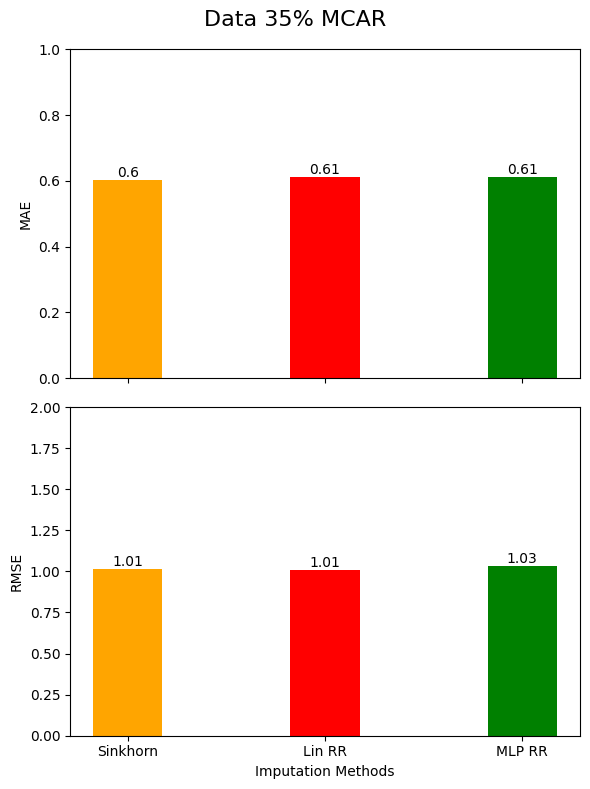

In [65]:

# Define values and categories
valuesOT_mae_mcar35 = [sk_mae_mcar35,lin_rr_mae_mcar35,mlp_rr_mae_mcar35]
valuesOT_rmse_mcar35 = [sk_rmse_mcar35,lin_rr_rmse_mcar35,mlp_rr_rmse_mcar35]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 35% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**40% MCAR**

In [66]:
#sinkhorn
n_mcar40, d_mcar40 = data_mcar40.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar40 = pick_epsilon(data_mcar40)

print(epsilon_mcar40)

sk_imputer_mcar40 = SinkhornImputation(eps=epsilon_mcar40, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar40, sk_maes40mcar, sk_rmses40mcar = sk_imputer_mcar40.fit_transform(data_mcar40, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar40_numpy = sk_imp_mcar40.detach().cpu().numpy()

sk_mae_mcar40 = MAE(sk_imp_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
sk_rmse_mcar40 = RMSE(sk_imp_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(sk_mae_mcar40,sk_rmse_mcar40)

INFO:root:batchsize = 128, epsilon = 0.2738
INFO:root:Iteration 0:	 Loss: 2.3062	 Validation MAE: 0.6836	RMSE: 1.0017


0.2738042100067056


INFO:root:Iteration 500:	 Loss: 2.1314	 Validation MAE: 0.6469	RMSE: 1.0034
INFO:root:Iteration 1000:	 Loss: 2.0008	 Validation MAE: 0.6244	RMSE: 1.0067
INFO:root:Iteration 1500:	 Loss: 2.2298	 Validation MAE: 0.6108	RMSE: 1.0106


0.6027617879918699 1.0144740720025278


In [67]:
#linear Round Robin
dmcar40_ = d_mcar40 - 1
models_liner_mcar40 = {}

for i in range(d_mcar40):
    models_liner_mcar40[i] = nn.Linear(dmcar40_, 1)

#Create the imputer
lin_rr_imputer_mcar40 = RRimputer(models_liner_mcar40, eps=epsilon_mcar40, lr=lr)
lin_rr_mcar40, lin_maesmcar40, lin_rmsesmcar40 = lin_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)
lin_rr_mcar40_numpy = lin_rr_mcar40.detach().cpu().numpy()

lin_rr_mae_mcar40 = MAE(lin_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
lin_rr_rmse_mcar40 = RMSE(lin_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(lin_rr_mae_mcar40,lin_rr_rmse_mcar40)

INFO:root:Iteration 0:	 Loss: 2.5058	Validation MAE: 0.6900	RMSE:  1.0195
INFO:root:Iteration 1:	 Loss: 2.5829	Validation MAE: 0.6333	RMSE:  1.0033
INFO:root:Iteration 2:	 Loss: 2.4845	Validation MAE: 0.6176	RMSE:  1.0039
INFO:root:Iteration 3:	 Loss: 2.3889	Validation MAE: 0.6141	RMSE:  1.0063
INFO:root:Iteration 4:	 Loss: 2.3613	Validation MAE: 0.6136	RMSE:  1.0082
INFO:root:Iteration 5:	 Loss: 2.4954	Validation MAE: 0.6139	RMSE:  1.0090
INFO:root:Iteration 6:	 Loss: 2.3093	Validation MAE: 0.6164	RMSE:  1.0112
INFO:root:Iteration 7:	 Loss: 2.3770	Validation MAE: 0.6197	RMSE:  1.0138
INFO:root:Iteration 8:	 Loss: 2.2408	Validation MAE: 0.6199	RMSE:  1.0147
INFO:root:Iteration 9:	 Loss: 2.4357	Validation MAE: 0.6212	RMSE:  1.0145
INFO:root:Early stopping criterion not reached


0.6211793679008191 1.0145495203177366


In [68]:
#MLP Round Robin
dmcar40_ = d_mcar40 - 1
models_mlp_mcar40 = {}


for i in range(d_mcar40):
   models_mlp_mcar40[i] = nn.Sequential(nn.Linear(dmcar40_, 2 * dmcar40_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar40_, dmcar40_),
                              nn.ReLU(),
                              nn.Linear(dmcar40_, 1))

#Create the imputer
mlp_rr_imputer_mcar40 = RRimputer(models_mlp_mcar40, eps=epsilon_mcar40, lr=lr)

mlp_rr_mcar40, mlp_rr_maesmcar40, mlp_rr_rmsesmcar40 = mlp_rr_imputer_mcar40.fit_transform(data_mcar40, verbose=True, X_true=ground_truth)

mlp_rr_mcar40_numpy = mlp_rr_mcar40.detach().cpu().numpy()

mlp_rr_mae_mcar40 = MAE(mlp_rr_mcar40_numpy,ground_truth_numpy ,mask_mcar40)
mlp_rr_rmse_mcar40 = RMSE(mlp_rr_mcar40_numpy, ground_truth_numpy,mask_mcar40)
print(mlp_rr_mae_mcar40, mlp_rr_rmse_mcar40)

INFO:root:Iteration 0:	 Loss: 2.4325	Validation MAE: 0.6079	RMSE:  1.0046
INFO:root:Iteration 1:	 Loss: 2.6288	Validation MAE: 0.6099	RMSE:  1.0058
INFO:root:Iteration 2:	 Loss: 2.4630	Validation MAE: 0.6110	RMSE:  1.0239
INFO:root:Iteration 3:	 Loss: 2.3986	Validation MAE: 0.6207	RMSE:  1.0315
INFO:root:Iteration 4:	 Loss: 2.2785	Validation MAE: 0.6180	RMSE:  1.0287
INFO:root:Iteration 5:	 Loss: 2.4713	Validation MAE: 0.6181	RMSE:  1.0422
INFO:root:Iteration 6:	 Loss: 2.3437	Validation MAE: 0.6235	RMSE:  1.0372
INFO:root:Iteration 7:	 Loss: 2.3837	Validation MAE: 0.6247	RMSE:  1.0425
INFO:root:Iteration 8:	 Loss: 2.4533	Validation MAE: 0.6264	RMSE:  1.0471
INFO:root:Iteration 9:	 Loss: 2.3782	Validation MAE: 0.6261	RMSE:  1.0442
INFO:root:Early stopping criterion not reached


0.626147565712464 1.0441831975510885


In [69]:
#mean
#using numpy version of data
mean_imp_mcar40 = SimpleImputer().fit_transform(data_mcar40_numpy)
mean_mae_mcar40 = MAE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
mean_rmse_mcar40= RMSE(mean_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(mean_mae_mcar40, mean_rmse_mcar40)

#ICE
ice_imp_mcar40 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar40_numpy)
ice_mae_mcar40 = MAE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
ice_rmse_mcar40 = RMSE(ice_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(ice_mae_mcar40,ice_rmse_mcar40)

#SoftImpute
cv_error_mcar40, grid_lambda_mcar40 = cv_softimpute(data_mcar40_numpy, grid_len=15)
lbda_mcar40 = grid_lambda_mcar40[np.argmin(cv_error_mcar40)]
soft_imp_mcar40 = softimpute((data_mcar40_numpy), lbda_mcar40)[1]

soft_mae_mcar40 = MAE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
soft_rmse_mcar40 = RMSE(soft_imp_mcar40, ground_truth_numpy, mask_mcar40)
print(soft_mae_mcar40,soft_rmse_mcar40)

0.6811907441959804 0.9968893521549548
0.770006039968514 1.110352086241052
0.6704888286477819 0.9867782092671367


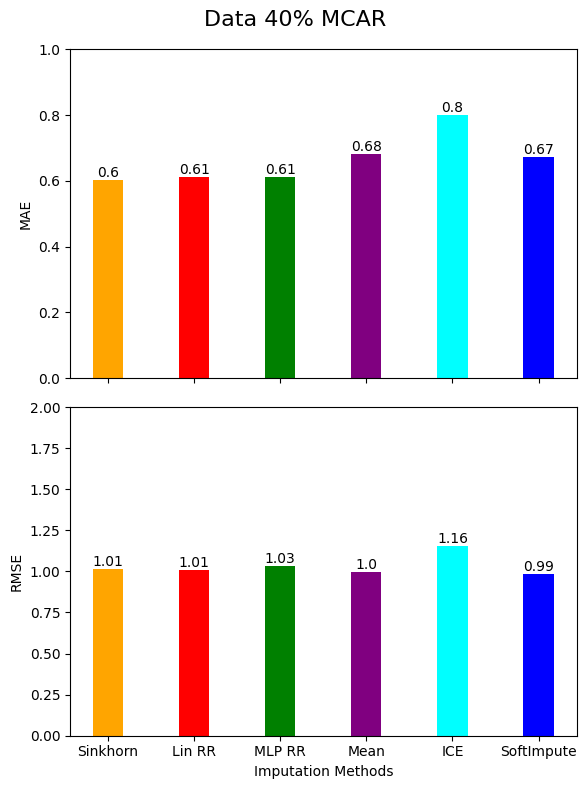

In [70]:

# Define values and categories
values_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40, mean_mae_mcar40, ice_mae_mcar40, soft_mae_mcar40]
values_rmse_mcar40 = [sk_rmse_mcar40, lin_rr_rmse_mcar40, mlp_rr_rmse_mcar40, mean_rmse_mcar40, ice_rmse_mcar40, soft_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar35, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar35, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


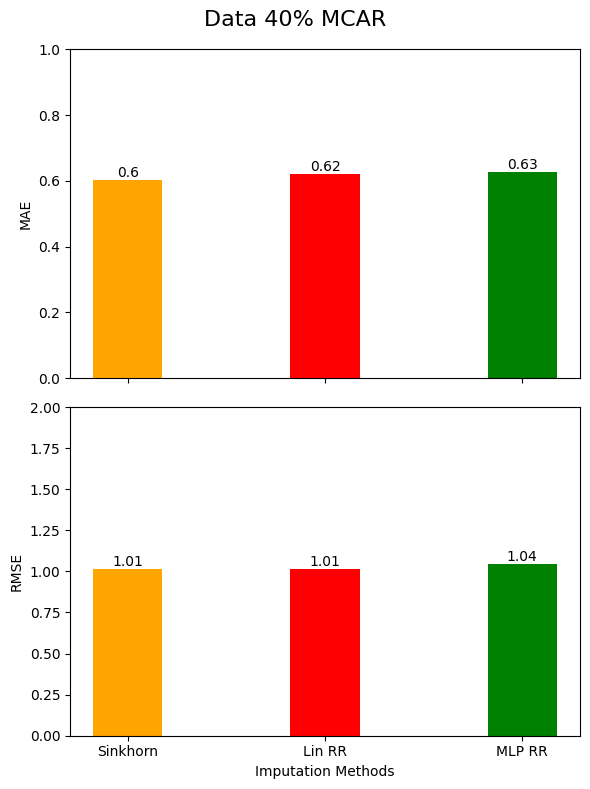

In [71]:

# Define values and categories
valuesOT_mae_mcar40 = [sk_mae_mcar40,lin_rr_mae_mcar40,mlp_rr_mae_mcar40]
valuesOT_rmse_mcar40 = [sk_rmse_mcar40,lin_rr_rmse_mcar40,mlp_rr_rmse_mcar40]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 40% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar40, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar40, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**45% MCAR**

In [72]:
#sinkhorn
n_mcar45, d_mcar45 = data_mcar45.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar45 = pick_epsilon(data_mcar45)

print(epsilon_mcar45)

sk_imputer_mcar45 = SinkhornImputation(eps=epsilon_mcar45, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar45, sk_maes45mcar, sk_rmses45mcar = sk_imputer_mcar45.fit_transform(data_mcar45, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar45_numpy = sk_imp_mcar45.detach().cpu().numpy()

sk_mae_mcar45 = MAE(sk_imp_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
sk_rmse_mcar45 = RMSE(sk_imp_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(sk_mae_mcar45,sk_rmse_mcar45)

INFO:root:batchsize = 128, epsilon = 0.2423


0.24230900877142628


INFO:root:Iteration 0:	 Loss: 2.5149	 Validation MAE: 0.6843	RMSE: 1.0022
INFO:root:Iteration 500:	 Loss: 2.1227	 Validation MAE: 0.6499	RMSE: 1.0039
INFO:root:Iteration 1000:	 Loss: 2.9025	 Validation MAE: 0.6274	RMSE: 1.0064
INFO:root:Iteration 1500:	 Loss: 2.0613	 Validation MAE: 0.6129	RMSE: 1.0095


0.6044032639051269 1.0129293285174688


In [73]:
#linear Round Robin
dmcar45_ = d_mcar45 - 1
models_liner_mcar45 = {}

for i in range(d_mcar45):
    models_liner_mcar45[i] = nn.Linear(dmcar45_, 1)

#Create the imputer
lin_rr_imputer_mcar45 = RRimputer(models_liner_mcar45, eps=epsilon_mcar45, lr=lr)
lin_rr_mcar45, lin_maesmcar45, lin_rmsesmcar45 = lin_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)
lin_rr_mcar45_numpy = lin_rr_mcar45.detach().cpu().numpy()

lin_rr_mae_mcar45 = MAE(lin_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
lin_rr_rmse_mcar45 = RMSE(lin_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(lin_rr_mae_mcar45,lin_rr_rmse_mcar45)

INFO:root:Iteration 0:	 Loss: 2.1508	Validation MAE: 0.6674	RMSE:  1.0200
INFO:root:Iteration 1:	 Loss: 2.2583	Validation MAE: 0.6230	RMSE:  1.0064
INFO:root:Iteration 2:	 Loss: 2.2538	Validation MAE: 0.6190	RMSE:  1.0074
INFO:root:Iteration 3:	 Loss: 2.3865	Validation MAE: 0.6203	RMSE:  1.0100
INFO:root:Iteration 4:	 Loss: 2.2210	Validation MAE: 0.6224	RMSE:  1.0155
INFO:root:Iteration 5:	 Loss: 2.3543	Validation MAE: 0.6211	RMSE:  1.0167
INFO:root:Iteration 6:	 Loss: 1.9890	Validation MAE: 0.6248	RMSE:  1.0186
INFO:root:Iteration 7:	 Loss: 2.2101	Validation MAE: 0.6263	RMSE:  1.0213
INFO:root:Iteration 8:	 Loss: 2.3728	Validation MAE: 0.6306	RMSE:  1.0232
INFO:root:Iteration 9:	 Loss: 2.2854	Validation MAE: 0.6309	RMSE:  1.0221
INFO:root:Early stopping criterion not reached


0.6309285933190389 1.0221323579011299


In [74]:
#MLP Round Robin
dmcar45_ = d_mcar45 - 1
models_mlp_mcar45 = {}


for i in range(d_mcar45):
   models_mlp_mcar45[i] = nn.Sequential(nn.Linear(dmcar45_, 2 * dmcar45_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar45_, dmcar45_),
                              nn.ReLU(),
                              nn.Linear(dmcar45_, 1))

#Create the imputer
mlp_rr_imputer_mcar45 = RRimputer(models_mlp_mcar45, eps=epsilon_mcar45, lr=lr)

mlp_rr_mcar45, mlp_rr_maesmcar45, mlp_rr_rmsesmcar45 = mlp_rr_imputer_mcar45.fit_transform(data_mcar45, verbose=True, X_true=ground_truth)

mlp_rr_mcar45_numpy = mlp_rr_mcar45.detach().cpu().numpy()

mlp_rr_mae_mcar45 = MAE(mlp_rr_mcar45_numpy,ground_truth_numpy ,mask_mcar45)
mlp_rr_rmse_mcar45 = RMSE(mlp_rr_mcar45_numpy, ground_truth_numpy,mask_mcar45)
print(mlp_rr_mae_mcar45, mlp_rr_rmse_mcar45)

INFO:root:Iteration 0:	 Loss: 2.2445	Validation MAE: 0.6169	RMSE:  1.0043
INFO:root:Iteration 1:	 Loss: 2.2199	Validation MAE: 0.6113	RMSE:  1.0116
INFO:root:Iteration 2:	 Loss: 2.3173	Validation MAE: 0.6220	RMSE:  1.0266
INFO:root:Iteration 3:	 Loss: 2.3109	Validation MAE: 0.6324	RMSE:  1.0390
INFO:root:Iteration 4:	 Loss: 2.3181	Validation MAE: 0.6260	RMSE:  1.0448
INFO:root:Iteration 5:	 Loss: 2.2954	Validation MAE: 0.6333	RMSE:  1.0463
INFO:root:Iteration 6:	 Loss: 2.4674	Validation MAE: 0.6357	RMSE:  1.0495
INFO:root:Iteration 7:	 Loss: 2.1524	Validation MAE: 0.6356	RMSE:  1.0558
INFO:root:Iteration 8:	 Loss: 2.2275	Validation MAE: 0.6379	RMSE:  1.0549
INFO:root:Iteration 9:	 Loss: 2.4425	Validation MAE: 0.6373	RMSE:  1.0591
INFO:root:Early stopping criterion not reached


0.6373354022145411 1.0591082312666638


In [75]:
#mean
#using numpy version of data
mean_imp_mcar45 = SimpleImputer().fit_transform(data_mcar45_numpy)
mean_mae_mcar45 = MAE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
mean_rmse_mcar45= RMSE(mean_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(mean_mae_mcar45, mean_rmse_mcar45)

#ICE
ice_imp_mcar45 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar45_numpy)
ice_mae_mcar45 = MAE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
ice_rmse_mcar45 = RMSE(ice_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(ice_mae_mcar45,ice_rmse_mcar45)

#SoftImpute
cv_error_mcar45, grid_lambda_mcar45 = cv_softimpute(data_mcar45_numpy, grid_len=15)
lbda_mcar45 = grid_lambda_mcar45[np.argmin(cv_error_mcar45)]
soft_imp_mcar45 = softimpute((data_mcar45_numpy), lbda_mcar45)[1]

soft_mae_mcar45 = MAE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
soft_rmse_mcar45 = RMSE(soft_imp_mcar45, ground_truth_numpy, mask_mcar45)
print(soft_mae_mcar45,soft_rmse_mcar45)

0.6815592291161806 0.9969782164807619


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.7972774962139249 1.1519464128995716
0.6702037431721539 0.986570639496533


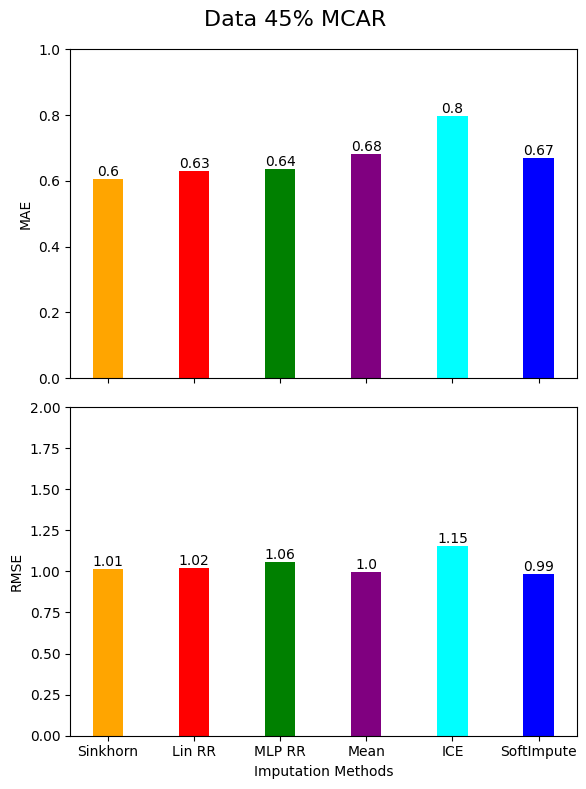

In [76]:

# Define values and categories
values_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45, mean_mae_mcar45, ice_mae_mcar45, soft_mae_mcar45]
values_rmse_mcar45 = [sk_rmse_mcar45, lin_rr_rmse_mcar45, mlp_rr_rmse_mcar45, mean_rmse_mcar45, ice_rmse_mcar45, soft_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


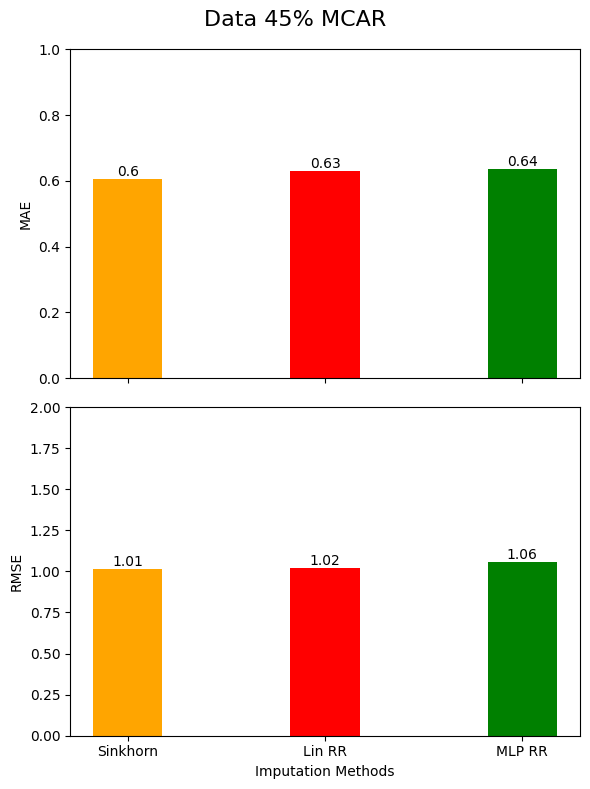

In [77]:

# Define values and categories
valuesOT_mae_mcar45 = [sk_mae_mcar45,lin_rr_mae_mcar45,mlp_rr_mae_mcar45]
valuesOT_rmse_mcar45 = [sk_rmse_mcar45,lin_rr_rmse_mcar45,mlp_rr_rmse_mcar45]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 45% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar45, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar45, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**50% MCAR**

In [78]:
#sinkhorn
n_mcar50, d_mcar50 = data_mcar50.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar50 = pick_epsilon(data_mcar50)

print(epsilon_mcar50)

sk_imputer_mcar50 = SinkhornImputation(eps=epsilon_mcar50, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar50, sk_maes50mcar, sk_rmses50mcar = sk_imputer_mcar50.fit_transform(data_mcar50, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar50_numpy = sk_imp_mcar50.detach().cpu().numpy()

sk_mae_mcar50 = MAE(sk_imp_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
sk_rmse_mcar50 = RMSE(sk_imp_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(sk_mae_mcar50,sk_rmse_mcar50)

INFO:root:batchsize = 128, epsilon = 0.2273
INFO:root:Iteration 0:	 Loss: 2.3695	 Validation MAE: 0.6838	RMSE: 1.0016


0.22726056171383624


INFO:root:Iteration 500:	 Loss: 1.8952	 Validation MAE: 0.6520	RMSE: 1.0030
INFO:root:Iteration 1000:	 Loss: 2.0252	 Validation MAE: 0.6293	RMSE: 1.0048
INFO:root:Iteration 1500:	 Loss: 1.6565	 Validation MAE: 0.6150	RMSE: 1.0081


0.6063140028962395 1.011757205978772


In [79]:
#linear Round Robin
dmcar50_ = d_mcar50 - 1
models_liner_mcar50 = {}

for i in range(d_mcar50):
    models_liner_mcar50[i] = nn.Linear(dmcar50_, 1)

#Create the imputer
lin_rr_imputer_mcar50 = RRimputer(models_liner_mcar50, eps=epsilon_mcar50, lr=lr)
lin_rr_mcar50, lin_maesmcar50, lin_rmsesmcar50 = lin_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)
lin_rr_mcar50_numpy = lin_rr_mcar50.detach().cpu().numpy()

lin_rr_mae_mcar50 = MAE(lin_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
lin_rr_rmse_mcar50 = RMSE(lin_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(lin_rr_mae_mcar50,lin_rr_rmse_mcar50)

INFO:root:Iteration 0:	 Loss: 2.2799	Validation MAE: 0.6700	RMSE:  1.0150
INFO:root:Iteration 1:	 Loss: 1.9324	Validation MAE: 0.6306	RMSE:  1.0044
INFO:root:Iteration 2:	 Loss: 2.1103	Validation MAE: 0.6239	RMSE:  1.0085
INFO:root:Iteration 3:	 Loss: 2.2610	Validation MAE: 0.6299	RMSE:  1.0154
INFO:root:Iteration 4:	 Loss: 2.0229	Validation MAE: 0.6329	RMSE:  1.0208
INFO:root:Iteration 5:	 Loss: 2.1526	Validation MAE: 0.6372	RMSE:  1.0249
INFO:root:Iteration 6:	 Loss: 2.1238	Validation MAE: 0.6412	RMSE:  1.0289
INFO:root:Iteration 7:	 Loss: 2.0990	Validation MAE: 0.6436	RMSE:  1.0330
INFO:root:Iteration 8:	 Loss: 2.4030	Validation MAE: 0.6427	RMSE:  1.0370
INFO:root:Iteration 9:	 Loss: 2.0435	Validation MAE: 0.6430	RMSE:  1.0364
INFO:root:Early stopping criterion not reached


0.6430467446421921 1.0364475059017593


In [80]:
#MLP Round Robin
dmcar50_ = d_mcar50 - 1
models_mlp_mcar50 = {}


for i in range(d_mcar50):
   models_mlp_mcar50[i] = nn.Sequential(nn.Linear(dmcar50_, 2 * dmcar50_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar50_, dmcar50_),
                              nn.ReLU(),
                              nn.Linear(dmcar50_, 1))

#Create the imputer
mlp_rr_imputer_mcar50 = RRimputer(models_mlp_mcar50, eps=epsilon_mcar50, lr=lr)

mlp_rr_mcar50, mlp_rr_maesmcar50, mlp_rr_rmsesmcar50 = mlp_rr_imputer_mcar50.fit_transform(data_mcar50, verbose=True, X_true=ground_truth)

mlp_rr_mcar50_numpy = mlp_rr_mcar50.detach().cpu().numpy()

mlp_rr_mae_mcar50 = MAE(mlp_rr_mcar50_numpy,ground_truth_numpy ,mask_mcar50)
mlp_rr_rmse_mcar50 = RMSE(mlp_rr_mcar50_numpy, ground_truth_numpy,mask_mcar50)
print(mlp_rr_mae_mcar50, mlp_rr_rmse_mcar50)

INFO:root:Iteration 0:	 Loss: 2.0820	Validation MAE: 0.6192	RMSE:  1.0010
INFO:root:Iteration 1:	 Loss: 2.1877	Validation MAE: 0.6220	RMSE:  1.0203
INFO:root:Iteration 2:	 Loss: 1.9896	Validation MAE: 0.6237	RMSE:  1.0387
INFO:root:Iteration 3:	 Loss: 2.0956	Validation MAE: 0.6377	RMSE:  1.0494
INFO:root:Iteration 4:	 Loss: 2.1636	Validation MAE: 0.6439	RMSE:  1.0587
INFO:root:Iteration 5:	 Loss: 2.1510	Validation MAE: 0.6436	RMSE:  1.0712
INFO:root:Iteration 6:	 Loss: 1.9768	Validation MAE: 0.6537	RMSE:  1.0807
INFO:root:Iteration 7:	 Loss: 2.3217	Validation MAE: 0.6530	RMSE:  1.0776
INFO:root:Iteration 8:	 Loss: 2.0559	Validation MAE: 0.6527	RMSE:  1.0906
INFO:root:Iteration 9:	 Loss: 2.3657	Validation MAE: 0.6560	RMSE:  1.0943
INFO:root:Early stopping criterion not reached


0.6559951182469609 1.0942638270742522


In [81]:
#mean
#using numpy version of data
mean_imp_mcar50 = SimpleImputer().fit_transform(data_mcar50_numpy)
mean_mae_mcar50 = MAE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
mean_rmse_mcar50= RMSE(mean_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(mean_mae_mcar50, mean_rmse_mcar50)

#ICE
ice_imp_mcar50 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar50_numpy)
ice_mae_mcar50 = MAE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
ice_rmse_mcar50 = RMSE(ice_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(ice_mae_mcar50,ice_rmse_mcar50)

#SoftImpute
cv_error_mcar50, grid_lambda_mcar50 = cv_softimpute(data_mcar50_numpy, grid_len=15)
lbda_mcar50 = grid_lambda_mcar50[np.argmin(cv_error_mcar50)]
soft_imp_mcar50 = softimpute((data_mcar50_numpy), lbda_mcar50)[1]

soft_mae_mcar50 = MAE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
soft_rmse_mcar50 = RMSE(soft_imp_mcar50, ground_truth_numpy, mask_mcar50)
print(soft_mae_mcar50,soft_rmse_mcar50)

0.6815002074301875 0.9964610295797088


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.7652715038806122 1.1111878265795927
0.6705703114945798 0.9869916332553171


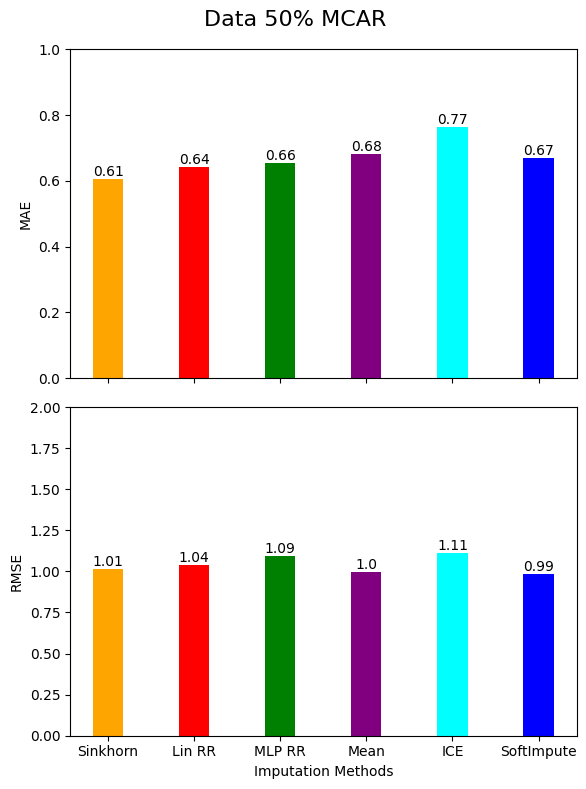

In [82]:

# Define values and categories
values_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50, mean_mae_mcar50, ice_mae_mcar50, soft_mae_mcar50]
values_rmse_mcar50 = [sk_rmse_mcar50, lin_rr_rmse_mcar50, mlp_rr_rmse_mcar50, mean_rmse_mcar50, ice_rmse_mcar50, soft_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


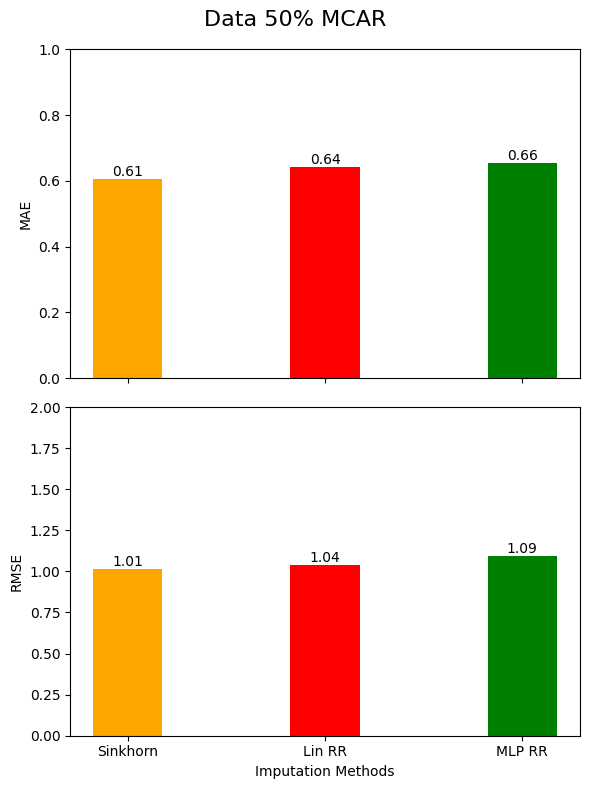

In [83]:

# Define values and categories
valuesOT_mae_mcar50 = [sk_mae_mcar50,lin_rr_mae_mcar50,mlp_rr_mae_mcar50]
valuesOT_rmse_mcar50 = [sk_rmse_mcar50,lin_rr_rmse_mcar50,mlp_rr_rmse_mcar50]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 50% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar50, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar50, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


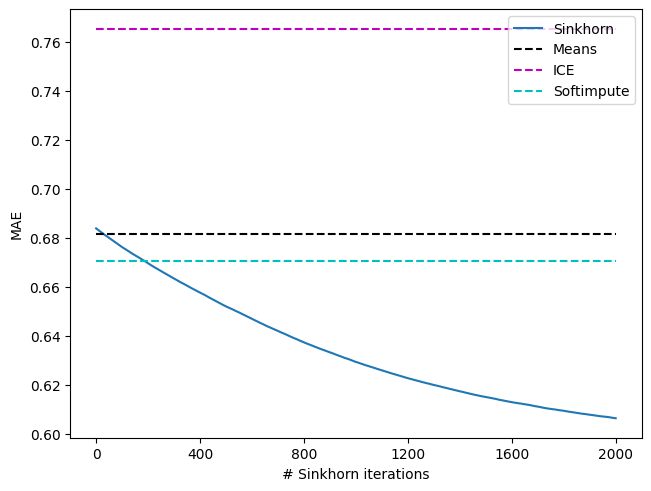

In [84]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

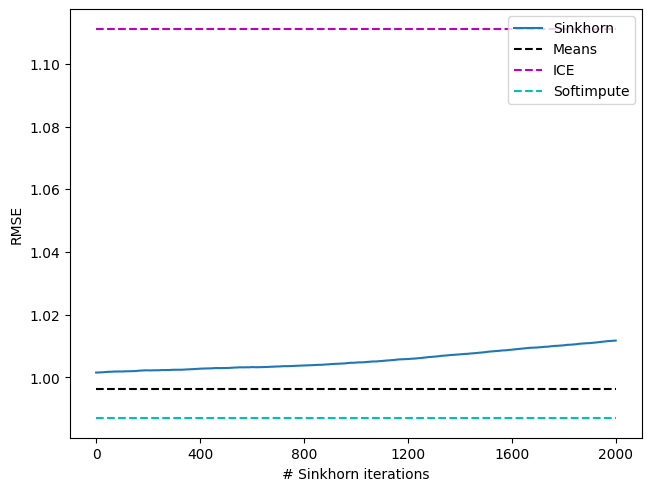

In [85]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses50mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses50mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar50, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar50, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar50, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

60% MCAR

In [86]:
#sinkhorn
n_mcar60, d_mcar60 = data_mcar60.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar60 = pick_epsilon(data_mcar60)

print(epsilon_mcar60)

sk_imputer_mcar60 = SinkhornImputation(eps=epsilon_mcar60, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar60, sk_maes60mcar, sk_rmses60mcar = sk_imputer_mcar60.fit_transform(data_mcar60, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar60_numpy = sk_imp_mcar60.detach().cpu().numpy()

sk_mae_mcar60 = MAE(sk_imp_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
sk_rmse_mcar60 = RMSE(sk_imp_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(sk_mae_mcar60,sk_rmse_mcar60)

INFO:root:batchsize = 128, epsilon = 0.1648
INFO:root:Iteration 0:	 Loss: 1.6905	 Validation MAE: 0.6844	RMSE: 1.0020


0.16480433934244715


INFO:root:Iteration 500:	 Loss: 1.5843	 Validation MAE: 0.6583	RMSE: 1.0026
INFO:root:Iteration 1000:	 Loss: 1.3577	 Validation MAE: 0.6381	RMSE: 1.0041
INFO:root:Iteration 1500:	 Loss: 1.5478	 Validation MAE: 0.6233	RMSE: 1.0064


0.6135999997897429 1.009131390977268


In [87]:
#linear Round Robin
dmcar60_ = d_mcar60 - 1
models_liner_mcar60 = {}

for i in range(d_mcar60):
    models_liner_mcar60[i] = nn.Linear(dmcar60_, 1)

#Create the imputer
lin_rr_imputer_mcar60 = RRimputer(models_liner_mcar60, eps=epsilon_mcar60, lr=lr)
lin_rr_mcar60, lin_maesmcar60, lin_rmsesmcar60 = lin_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)
lin_rr_mcar60_numpy = lin_rr_mcar60.detach().cpu().numpy()

lin_rr_mae_mcar60 = MAE(lin_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
lin_rr_rmse_mcar60 = RMSE(lin_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(lin_rr_mae_mcar60,lin_rr_rmse_mcar60)

INFO:root:Iteration 0:	 Loss: 1.8872	Validation MAE: 0.6700	RMSE:  1.0270
INFO:root:Iteration 1:	 Loss: 1.7137	Validation MAE: 0.6547	RMSE:  1.0341
INFO:root:Iteration 2:	 Loss: 1.8646	Validation MAE: 0.6550	RMSE:  1.0354
INFO:root:Iteration 3:	 Loss: 1.7886	Validation MAE: 0.6602	RMSE:  1.0441
INFO:root:Iteration 4:	 Loss: 1.9311	Validation MAE: 0.6642	RMSE:  1.0497
INFO:root:Iteration 5:	 Loss: 1.8405	Validation MAE: 0.6678	RMSE:  1.0541
INFO:root:Iteration 6:	 Loss: 1.7525	Validation MAE: 0.6691	RMSE:  1.0584
INFO:root:Iteration 7:	 Loss: 1.7019	Validation MAE: 0.6734	RMSE:  1.0614
INFO:root:Iteration 8:	 Loss: 1.7833	Validation MAE: 0.6711	RMSE:  1.0615
INFO:root:Iteration 9:	 Loss: 2.1237	Validation MAE: 0.6754	RMSE:  1.0669
INFO:root:Early stopping criterion not reached


0.6753968358453117 1.066928056368492


In [88]:
#MLP Round Robin
dmcar60_ = d_mcar60 - 1
models_mlp_mcar60 = {}


for i in range(d_mcar60):
   models_mlp_mcar60[i] = nn.Sequential(nn.Linear(dmcar60_, 2 * dmcar60_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar60_, dmcar60_),
                              nn.ReLU(),
                              nn.Linear(dmcar60_, 1))

#Create the imputer
mlp_rr_imputer_mcar60 = RRimputer(models_mlp_mcar60, eps=epsilon_mcar60, lr=lr)

mlp_rr_mcar60, mlp_rr_maesmcar60, mlp_rr_rmsesmcar60 = mlp_rr_imputer_mcar60.fit_transform(data_mcar60, verbose=True, X_true=ground_truth)

mlp_rr_mcar60_numpy = mlp_rr_mcar60.detach().cpu().numpy()

mlp_rr_mae_mcar60 = MAE(mlp_rr_mcar60_numpy,ground_truth_numpy ,mask_mcar60)
mlp_rr_rmse_mcar60 = RMSE(mlp_rr_mcar60_numpy, ground_truth_numpy,mask_mcar60)
print(mlp_rr_mae_mcar60, mlp_rr_rmse_mcar60)

INFO:root:Iteration 0:	 Loss: 1.6866	Validation MAE: 0.6303	RMSE:  1.0048
INFO:root:Iteration 1:	 Loss: 1.7927	Validation MAE: 0.6446	RMSE:  1.0535
INFO:root:Iteration 2:	 Loss: 2.0116	Validation MAE: 0.6592	RMSE:  1.0744
INFO:root:Iteration 3:	 Loss: 1.8668	Validation MAE: 0.6751	RMSE:  1.0943
INFO:root:Iteration 4:	 Loss: 1.8261	Validation MAE: 0.6895	RMSE:  1.1189
INFO:root:Iteration 5:	 Loss: 1.8997	Validation MAE: 0.6987	RMSE:  1.1405
INFO:root:Iteration 6:	 Loss: 1.8174	Validation MAE: 0.6993	RMSE:  1.1449
INFO:root:Iteration 7:	 Loss: 2.1524	Validation MAE: 0.7116	RMSE:  1.1679
INFO:root:Iteration 8:	 Loss: 1.9443	Validation MAE: 0.7011	RMSE:  1.1540
INFO:root:Iteration 9:	 Loss: 2.1044	Validation MAE: 0.7048	RMSE:  1.1525
INFO:root:Early stopping criterion not reached


0.7048094549183824 1.152478008304677


In [89]:
#mean
#using numpy version of data
mean_imp_mcar60 = SimpleImputer().fit_transform(data_mcar60_numpy)
mean_mae_mcar60 = MAE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
mean_rmse_mcar60= RMSE(mean_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(mean_mae_mcar60, mean_rmse_mcar60)

#ICE
ice_imp_mcar60 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar60_numpy)
ice_mae_mcar60 = MAE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
ice_rmse_mcar60 = RMSE(ice_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(ice_mae_mcar60,ice_rmse_mcar60)

#SoftImpute
cv_error_mcar60, grid_lambda_mcar60 = cv_softimpute(data_mcar60_numpy, grid_len=15)
lbda_mcar60 = grid_lambda_mcar60[np.argmin(cv_error_mcar60)]
soft_imp_mcar60 = softimpute((data_mcar60_numpy), lbda_mcar60)[1]

soft_mae_mcar60 = MAE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
soft_rmse_mcar60 = RMSE(soft_imp_mcar60, ground_truth_numpy, mask_mcar60)
print(soft_mae_mcar60,soft_rmse_mcar60)

0.6818438484950461 0.9967548907799376
0.7230992673436701 1.0587523145213358
0.6731972499528011 0.9892058741167906


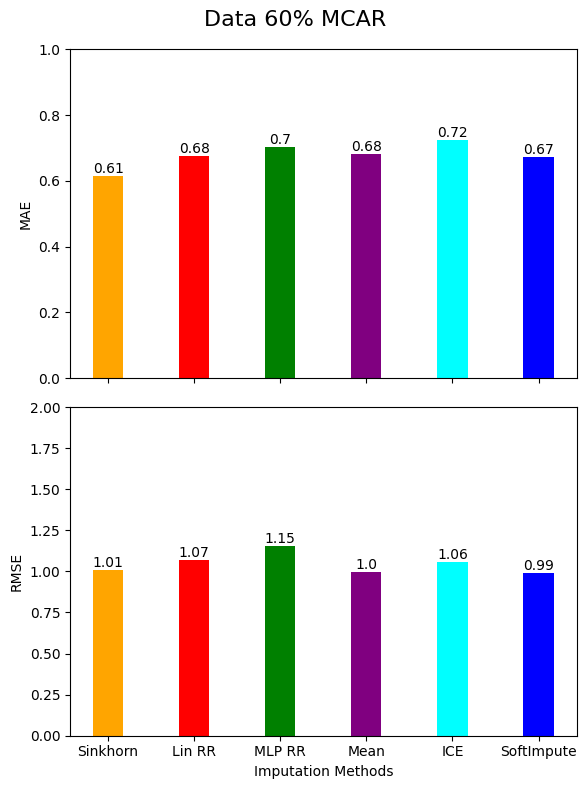

In [90]:

# Define values and categories
values_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60, mean_mae_mcar60, ice_mae_mcar60, soft_mae_mcar60]
values_rmse_mcar60 = [sk_rmse_mcar60, lin_rr_rmse_mcar60, mlp_rr_rmse_mcar60, mean_rmse_mcar60, ice_rmse_mcar60, soft_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


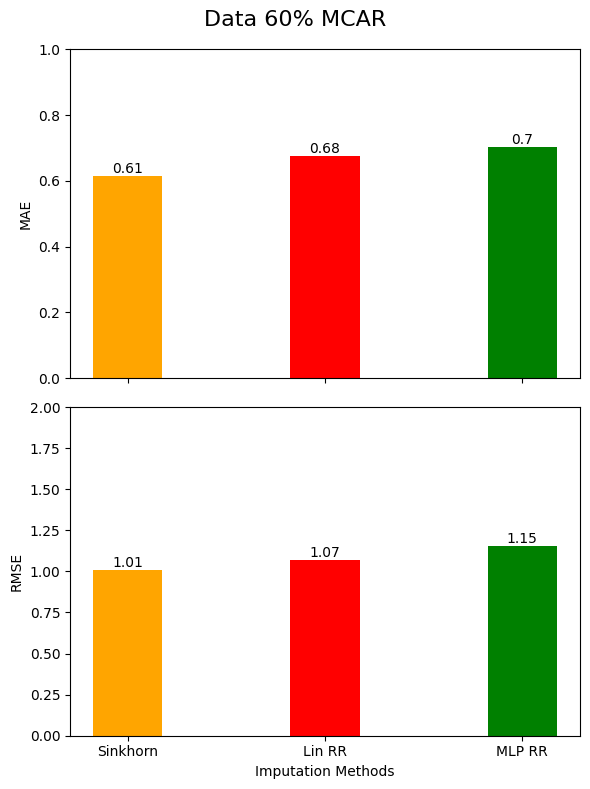

In [91]:

# Define values and categories
valuesOT_mae_mcar60 = [sk_mae_mcar60,lin_rr_mae_mcar60,mlp_rr_mae_mcar60]
valuesOT_rmse_mcar60 = [sk_rmse_mcar60,lin_rr_rmse_mcar60,mlp_rr_rmse_mcar60]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 60% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar60, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar60, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


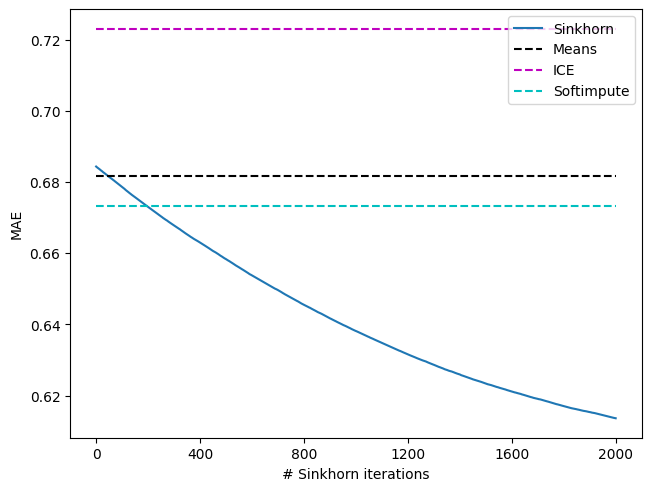

In [92]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

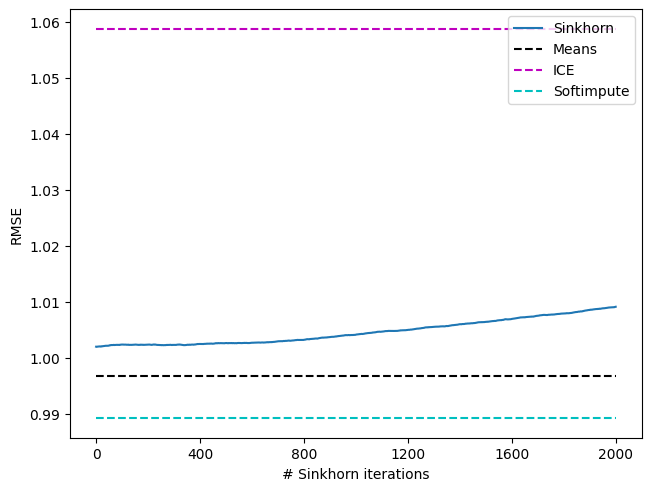

In [93]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses60mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses60mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar60, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar60, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar60, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

70% MCAR

In [94]:
#sinkhorn
n_mcar70, d_mcar70 = data_mcar70.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar70 = pick_epsilon(data_mcar70)

print(epsilon_mcar70)

sk_imputer_mcar70 = SinkhornImputation(eps=epsilon_mcar70, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar70, sk_maes70mcar, sk_rmses70mcar = sk_imputer_mcar70.fit_transform(data_mcar70, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar70_numpy = sk_imp_mcar70.detach().cpu().numpy()

sk_mae_mcar70 = MAE(sk_imp_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
sk_rmse_mcar70 = RMSE(sk_imp_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(sk_mae_mcar70,sk_rmse_mcar70)

INFO:root:batchsize = 128, epsilon = 0.1118
INFO:root:Iteration 0:	 Loss: 1.1173	 Validation MAE: 0.6837	RMSE: 1.0034


0.11176111374820051


INFO:root:Iteration 500:	 Loss: 1.2866	 Validation MAE: 0.6643	RMSE: 1.0037
INFO:root:Iteration 1000:	 Loss: 1.0311	 Validation MAE: 0.6478	RMSE: 1.0043
INFO:root:Iteration 1500:	 Loss: 1.0792	 Validation MAE: 0.6345	RMSE: 1.0061


0.6247722964632151 1.0085493437971147


In [95]:
#linear Round Robin
dmcar70_ = d_mcar70 - 1
models_liner_mcar70 = {}

for i in range(d_mcar70):
    models_liner_mcar70[i] = nn.Linear(dmcar70_, 1)

#Create the imputer
lin_rr_imputer_mcar70 = RRimputer(models_liner_mcar70, eps=epsilon_mcar70, lr=lr)
lin_rr_mcar70, lin_maesmcar70, lin_rmsesmcar70 = lin_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)
lin_rr_mcar70_numpy = lin_rr_mcar70.detach().cpu().numpy()

lin_rr_mae_mcar70 = MAE(lin_rr_mcar70_numpy,ground_truth_numpy,mask_mcar70)
lin_rr_rmse_mcar70 = RMSE(lin_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(lin_rr_mae_mcar70,lin_rr_rmse_mcar70)

INFO:root:Iteration 0:	 Loss: 1.5237	Validation MAE: 0.6786	RMSE:  1.0273
INFO:root:Iteration 1:	 Loss: 1.6162	Validation MAE: 0.6738	RMSE:  1.0468
INFO:root:Iteration 2:	 Loss: 1.7617	Validation MAE: 0.6939	RMSE:  1.0767
INFO:root:Iteration 3:	 Loss: 1.5543	Validation MAE: 0.7146	RMSE:  1.0992
INFO:root:Iteration 4:	 Loss: 1.6606	Validation MAE: 0.7220	RMSE:  1.1040
INFO:root:Iteration 5:	 Loss: 1.7090	Validation MAE: 0.7226	RMSE:  1.1076
INFO:root:Iteration 6:	 Loss: 1.8451	Validation MAE: 0.7238	RMSE:  1.1167
INFO:root:Iteration 7:	 Loss: 1.9047	Validation MAE: 0.7344	RMSE:  1.1251
INFO:root:Iteration 8:	 Loss: 1.8452	Validation MAE: 0.7418	RMSE:  1.1353
INFO:root:Iteration 9:	 Loss: 1.8552	Validation MAE: 0.7355	RMSE:  1.1338
INFO:root:Early stopping criterion not reached


0.735470269207011 1.133841209613045


In [96]:
#MLP Round Robin
dmcar70_ = d_mcar70 - 1
models_mlp_mcar70 = {}


for i in range(d_mcar70):
   models_mlp_mcar70[i] = nn.Sequential(nn.Linear(dmcar70_, 2 * dmcar70_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar70_, dmcar70_),
                              nn.ReLU(),
                              nn.Linear(dmcar70_, 1))

#Create the imputer
mlp_rr_imputer_mcar70 = RRimputer(models_mlp_mcar70, eps=epsilon_mcar70, lr=lr)

mlp_rr_mcar70, mlp_rr_maesmcar70, mlp_rr_rmsesmcar70 = mlp_rr_imputer_mcar70.fit_transform(data_mcar70, verbose=True, X_true=ground_truth)

mlp_rr_mcar70_numpy = mlp_rr_mcar70.detach().cpu().numpy()

mlp_rr_mae_mcar70 = MAE(mlp_rr_mcar70_numpy,ground_truth_numpy ,mask_mcar70)
mlp_rr_rmse_mcar70 = RMSE(mlp_rr_mcar70_numpy, ground_truth_numpy,mask_mcar70)
print(mlp_rr_mae_mcar70, mlp_rr_rmse_mcar70)

INFO:root:Iteration 0:	 Loss: 1.5089	Validation MAE: 0.6318	RMSE:  1.0057
INFO:root:Iteration 1:	 Loss: 1.6385	Validation MAE: 0.6829	RMSE:  1.0802
INFO:root:Iteration 2:	 Loss: 1.7542	Validation MAE: 0.7049	RMSE:  1.1269
INFO:root:Iteration 3:	 Loss: 1.8865	Validation MAE: 0.7448	RMSE:  1.1931
INFO:root:Iteration 4:	 Loss: 1.7819	Validation MAE: 0.7425	RMSE:  1.2150
INFO:root:Iteration 5:	 Loss: 1.6909	Validation MAE: 0.7404	RMSE:  1.2175
INFO:root:Iteration 6:	 Loss: 1.8106	Validation MAE: 0.7457	RMSE:  1.2302
INFO:root:Iteration 7:	 Loss: 1.6297	Validation MAE: 0.7560	RMSE:  1.2364
INFO:root:Iteration 8:	 Loss: 1.7844	Validation MAE: 0.7573	RMSE:  1.2510
INFO:root:Iteration 9:	 Loss: 1.5945	Validation MAE: 0.7507	RMSE:  1.2389
INFO:root:Early stopping criterion not reached


0.7506772414705346 1.2388787116406494


In [97]:
#mean
#using numpy version of data
mean_imp_mcar70 = SimpleImputer().fit_transform(data_mcar70_numpy)
mean_mae_mcar70 = MAE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
mean_rmse_mcar70= RMSE(mean_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(mean_mae_mcar70, mean_rmse_mcar70)

#ICE
ice_imp_mcar70 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar70_numpy)
ice_mae_mcar70 = MAE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
ice_rmse_mcar70 = RMSE(ice_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(ice_mae_mcar70,ice_rmse_mcar70)

#SoftImpute
cv_error_mcar70, grid_lambda_mcar70 = cv_softimpute(data_mcar70_numpy, grid_len=15)
lbda_mcar70 = grid_lambda_mcar70[np.argmin(cv_error_mcar70)]
soft_imp_mcar70 = softimpute((data_mcar70_numpy), lbda_mcar70)[1]

soft_mae_mcar70 = MAE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
soft_rmse_mcar70 = RMSE(soft_imp_mcar70, ground_truth_numpy, mask_mcar70)
print(soft_mae_mcar70,soft_rmse_mcar70)

0.6815107625451577 0.9987311098283427
0.7136740466799057 1.0500549642788275
0.6750578141858967 0.9931019798967382


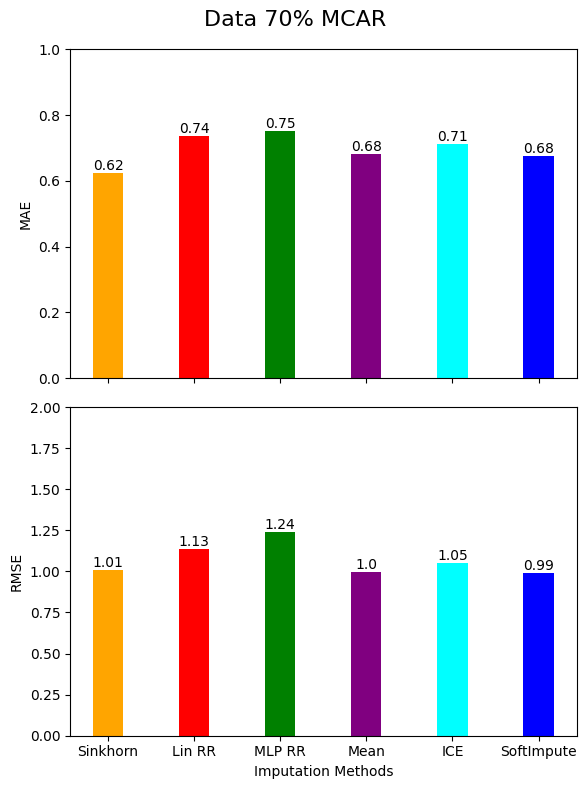

In [98]:

# Define values and categories
values_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70, mean_mae_mcar70, ice_mae_mcar70, soft_mae_mcar70]
values_rmse_mcar70 = [sk_rmse_mcar70, lin_rr_rmse_mcar70, mlp_rr_rmse_mcar70, mean_rmse_mcar70, ice_rmse_mcar70, soft_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


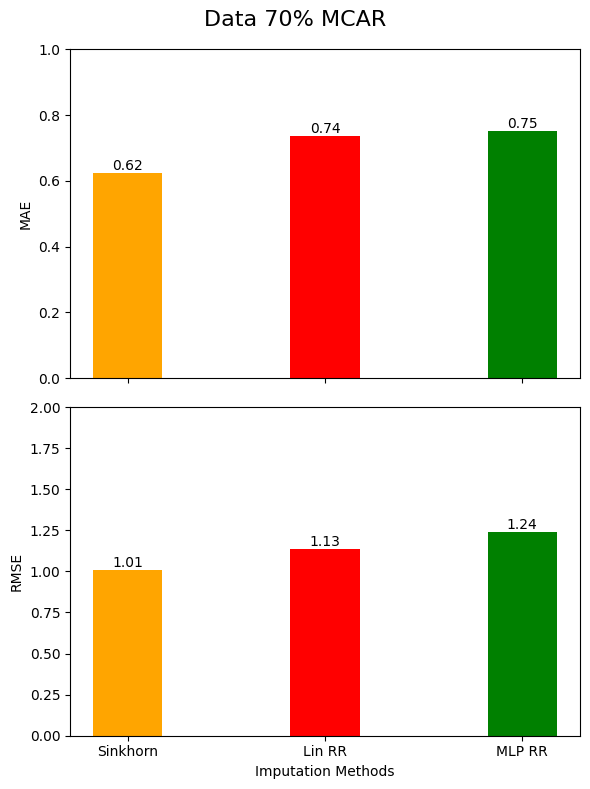

In [99]:

# Define values and categories
valuesOT_mae_mcar70 = [sk_mae_mcar70,lin_rr_mae_mcar70,mlp_rr_mae_mcar70]
valuesOT_rmse_mcar70 = [sk_rmse_mcar70,lin_rr_rmse_mcar70,mlp_rr_rmse_mcar70]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 70% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar70, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar70, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


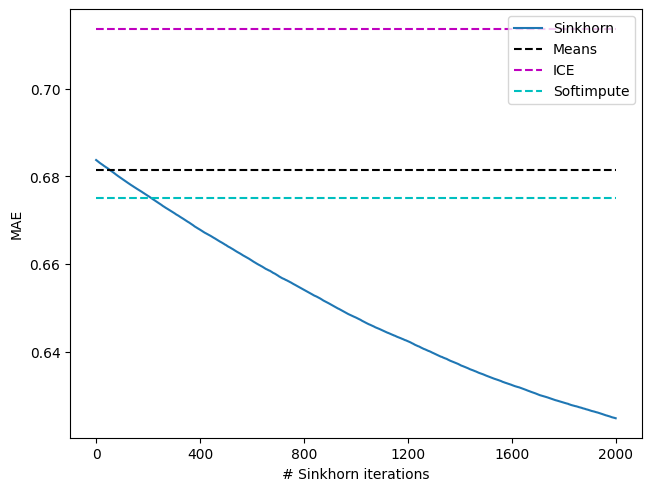

In [100]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

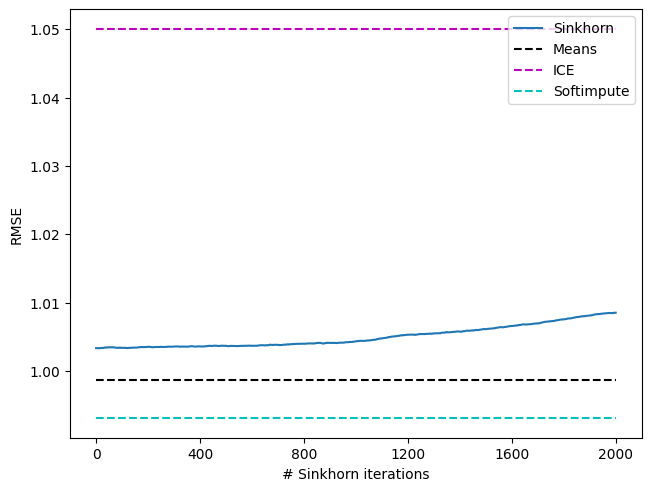

In [101]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses70mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses70mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar70, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar70, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar70, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

80% MCAR

In [102]:
#sinkhorn
n_mcar80, d_mcar80 = data_mcar80.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar80 = pick_epsilon(data_mcar80)

print(epsilon_mcar80)

sk_imputer_mcar80 = SinkhornImputation(eps=epsilon_mcar80, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar80, sk_maes80mcar, sk_rmses80mcar = sk_imputer_mcar80.fit_transform(data_mcar80, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar80_numpy = sk_imp_mcar80.detach().cpu().numpy()

sk_mae_mcar80 = MAE(sk_imp_mcar80_numpy,ground_truth_numpy ,mask_mcar80)
sk_rmse_mcar80 = RMSE(sk_imp_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(sk_mae_mcar80,sk_rmse_mcar80)

INFO:root:batchsize = 128, epsilon = 0.0709
INFO:root:Iteration 0:	 Loss: 0.8699	 Validation MAE: 0.6846	RMSE: 1.0028


0.07094731149698429


INFO:root:Iteration 500:	 Loss: 0.8376	 Validation MAE: 0.6722	RMSE: 1.0030
INFO:root:Iteration 1000:	 Loss: 0.9224	 Validation MAE: 0.6605	RMSE: 1.0031
INFO:root:Iteration 1500:	 Loss: 0.7246	 Validation MAE: 0.6502	RMSE: 1.0040


0.6412045310233903 1.0050841450429693


In [103]:
#linear Round Robin
dmcar80_ = d_mcar80 - 1
models_liner_mcar80 = {}

for i in range(d_mcar80):
    models_liner_mcar80[i] = nn.Linear(dmcar80_, 1)

#Create the imputer
lin_rr_imputer_mcar80 = RRimputer(models_liner_mcar80, eps=epsilon_mcar80, lr=lr)
lin_rr_mcar80, lin_maesmcar80, lin_rmsesmcar80 = lin_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)
lin_rr_mcar80_numpy = lin_rr_mcar80.detach().cpu().numpy()

lin_rr_mae_mcar80 = MAE(lin_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
lin_rr_rmse_mcar80 = RMSE(lin_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(lin_rr_mae_mcar80,lin_rr_rmse_mcar80)

INFO:root:Iteration 0:	 Loss: 1.3435	Validation MAE: 0.7008	RMSE:  1.0374
INFO:root:Iteration 1:	 Loss: 1.6074	Validation MAE: 0.7217	RMSE:  1.0882
INFO:root:Iteration 2:	 Loss: 1.6221	Validation MAE: 0.7402	RMSE:  1.1123
INFO:root:Iteration 3:	 Loss: 1.7257	Validation MAE: 0.7686	RMSE:  1.1465
INFO:root:Iteration 4:	 Loss: 1.9253	Validation MAE: 0.7763	RMSE:  1.1546
INFO:root:Iteration 5:	 Loss: 1.8371	Validation MAE: 0.7813	RMSE:  1.1565
INFO:root:Iteration 6:	 Loss: 1.8096	Validation MAE: 0.7819	RMSE:  1.1625
INFO:root:Iteration 7:	 Loss: 1.7594	Validation MAE: 0.7781	RMSE:  1.1563
INFO:root:Iteration 8:	 Loss: 1.8086	Validation MAE: 0.7860	RMSE:  1.1647
INFO:root:Iteration 9:	 Loss: 1.7800	Validation MAE: 0.7789	RMSE:  1.1611
INFO:root:Early stopping criterion not reached


0.778883701439028 1.161129205293221


In [104]:
#MLP Round Robin
dmcar80_ = d_mcar80 - 1
models_mlp_mcar80 = {}


for i in range(d_mcar80):
   models_mlp_mcar80[i] = nn.Sequential(nn.Linear(dmcar80_, 2 * dmcar80_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar80_, dmcar80_),
                              nn.ReLU(),
                              nn.Linear(dmcar80_, 1))

#Create the imputer
mlp_rr_imputer_mcar80 = RRimputer(models_mlp_mcar80, eps=epsilon_mcar80, lr=lr)

mlp_rr_mcar80, mlp_rr_maesmcar80, mlp_rr_rmsesmcar80 = mlp_rr_imputer_mcar80.fit_transform(data_mcar80, verbose=True, X_true=ground_truth)

mlp_rr_mcar80_numpy = mlp_rr_mcar80.detach().cpu().numpy()

mlp_rr_mae_mcar80 = MAE(mlp_rr_mcar80_numpy,ground_truth_numpy,mask_mcar80)
mlp_rr_rmse_mcar80 = RMSE(mlp_rr_mcar80_numpy, ground_truth_numpy,mask_mcar80)
print(mlp_rr_mae_mcar80, mlp_rr_rmse_mcar80)

INFO:root:Iteration 0:	 Loss: 1.3495	Validation MAE: 0.6729	RMSE:  1.0322
INFO:root:Iteration 1:	 Loss: 1.3046	Validation MAE: 0.7407	RMSE:  1.1604
INFO:root:Iteration 2:	 Loss: 1.5750	Validation MAE: 0.7592	RMSE:  1.1985
INFO:root:Iteration 3:	 Loss: 1.3725	Validation MAE: 0.7874	RMSE:  1.2378
INFO:root:Iteration 4:	 Loss: 1.3506	Validation MAE: 0.7763	RMSE:  1.2451
INFO:root:Iteration 5:	 Loss: 1.7427	Validation MAE: 0.7973	RMSE:  1.2944
INFO:root:Iteration 6:	 Loss: 1.5778	Validation MAE: 0.7825	RMSE:  1.2861
INFO:root:Iteration 7:	 Loss: 1.1902	Validation MAE: 0.7837	RMSE:  1.2691
INFO:root:Iteration 8:	 Loss: 1.7426	Validation MAE: 0.7927	RMSE:  1.3000
INFO:root:Iteration 9:	 Loss: 1.3038	Validation MAE: 0.7777	RMSE:  1.2603
INFO:root:Early stopping criterion not reached


0.7777364105428101 1.260261644762195


In [105]:
#mean
#using numpy version of data
mean_imp_mcar80 = SimpleImputer().fit_transform(data_mcar80_numpy)
mean_mae_mcar80 = MAE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
mean_rmse_mcar80= RMSE(mean_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(mean_mae_mcar80, mean_rmse_mcar80)

#ICE
ice_imp_mcar80 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar80_numpy)
ice_mae_mcar80 = MAE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
ice_rmse_mcar80 = RMSE(ice_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(ice_mae_mcar80,ice_rmse_mcar80)

#SoftImpute
cv_error_mcar80, grid_lambda_mcar80 = cv_softimpute(data_mcar80_numpy, grid_len=15)
lbda_mcar80 = grid_lambda_mcar80[np.argmin(cv_error_mcar80)]
soft_imp_mcar80 = softimpute((data_mcar80_numpy), lbda_mcar80)[1]

soft_mae_mcar80 = MAE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
soft_rmse_mcar80 = RMSE(soft_imp_mcar80, ground_truth_numpy, mask_mcar80)
print(soft_mae_mcar80,soft_rmse_mcar80)

0.6825358163127547 0.9980852178837178
0.7028447112794851 1.0292154191649108
0.6771695975656914 0.994398959310436


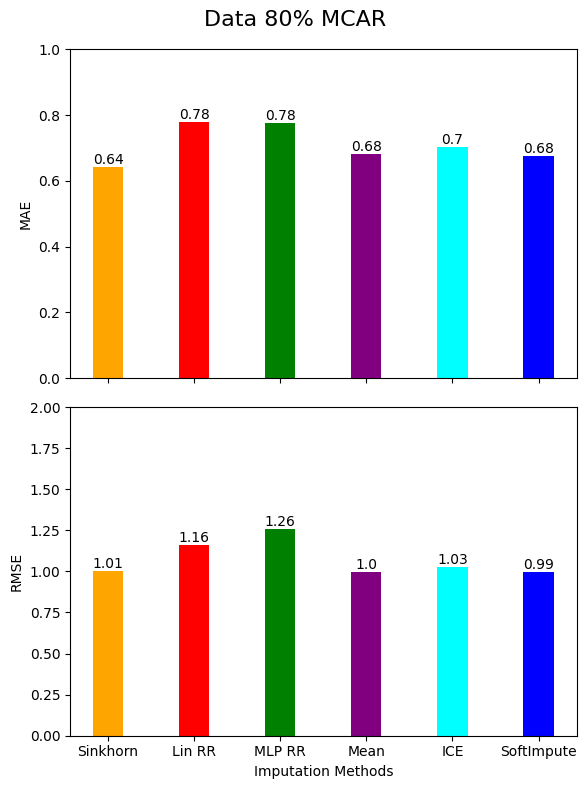

In [106]:

# Define values and categories
values_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80, mean_mae_mcar80, ice_mae_mcar80, soft_mae_mcar80]
values_rmse_mcar80 = [sk_rmse_mcar80, lin_rr_rmse_mcar80, mlp_rr_rmse_mcar80, mean_rmse_mcar80, ice_rmse_mcar80, soft_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


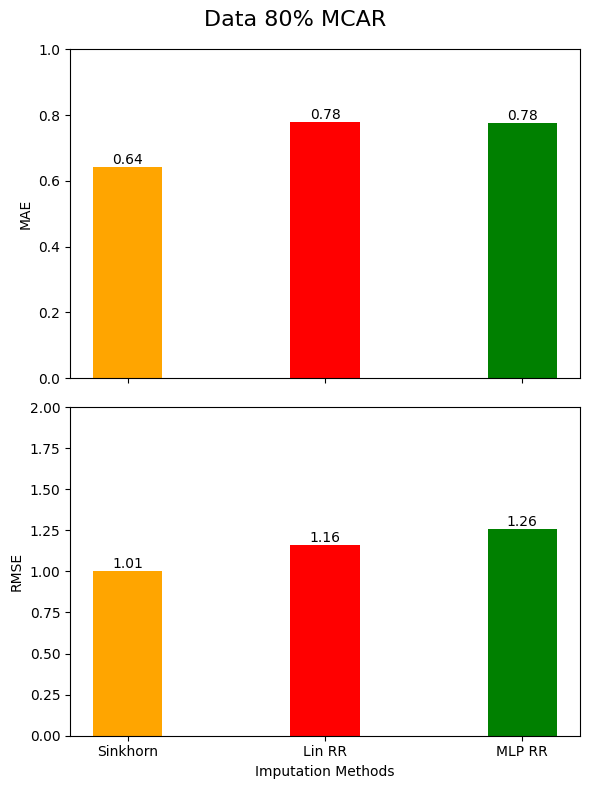

In [107]:

# Define values and categories
valuesOT_mae_mcar80 = [sk_mae_mcar80,lin_rr_mae_mcar80,mlp_rr_mae_mcar80]
valuesOT_rmse_mcar80 = [sk_rmse_mcar80,lin_rr_rmse_mcar80,mlp_rr_rmse_mcar80]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 80% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar80, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar80, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


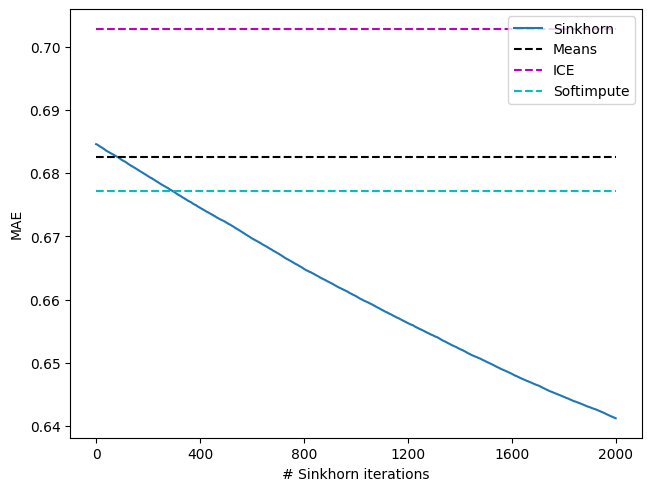

In [108]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

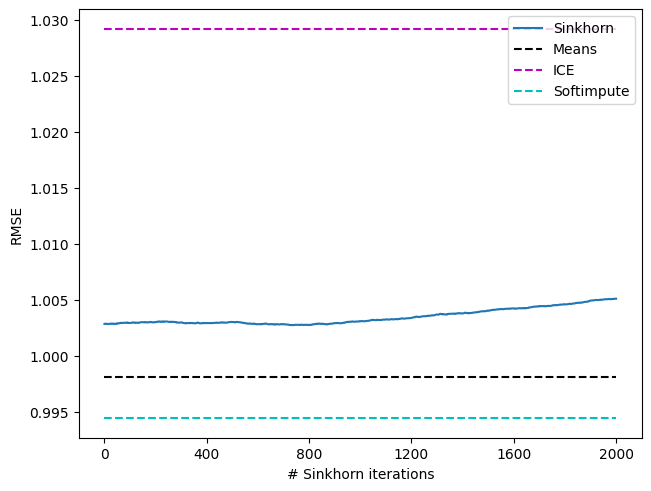

In [109]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses80mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses80mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar80, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar80, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar80, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

90% MCAR

In [110]:
#sinkhorn
n_mcar90, d_mcar90 = data_mcar90.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar90 = pick_epsilon(data_mcar90)

print(epsilon_mcar90)

sk_imputer_mcar90 = SinkhornImputation(eps=epsilon_mcar90, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar90, sk_maes90mcar, sk_rmses90mcar = sk_imputer_mcar90.fit_transform(data_mcar90, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar90_numpy = sk_imp_mcar90.detach().cpu().numpy()

sk_mae_mcar90 = MAE(sk_imp_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
sk_rmse_mcar90 = RMSE(sk_imp_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(sk_mae_mcar90,sk_rmse_mcar90)

INFO:root:batchsize = 128, epsilon = 0.0287
INFO:root:Iteration 0:	 Loss: 0.2815	 Validation MAE: 0.6852	RMSE: 1.0044


0.028685765891506117


INFO:root:Iteration 500:	 Loss: 0.7369	 Validation MAE: 0.6797	RMSE: 1.0043
INFO:root:Iteration 1000:	 Loss: 0.4825	 Validation MAE: 0.6743	RMSE: 1.0040
INFO:root:Iteration 1500:	 Loss: 0.4250	 Validation MAE: 0.6693	RMSE: 1.0043


0.6644747450457432 1.0047489219160242


In [111]:
#linear Round Robin
dmcar90_ = d_mcar90 - 1
models_liner_mcar90 = {}

for i in range(d_mcar90):
    models_liner_mcar90[i] = nn.Linear(dmcar90_, 1)

#Create the imputer
lin_rr_imputer_mcar90 = RRimputer(models_liner_mcar90, eps=epsilon_mcar90, lr=lr)
lin_rr_mcar90, lin_maesmcar90, lin_rmsesmcar90 = lin_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)
lin_rr_mcar90_numpy = lin_rr_mcar90.detach().cpu().numpy()

lin_rr_mae_mcar90 = MAE(lin_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
lin_rr_rmse_mcar90 = RMSE(lin_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(lin_rr_mae_mcar90,lin_rr_rmse_mcar90)

INFO:root:Iteration 0:	 Loss: 1.1861	Validation MAE: 0.7156	RMSE:  1.0532
INFO:root:Iteration 1:	 Loss: 1.3856	Validation MAE: 0.7584	RMSE:  1.1043
INFO:root:Iteration 2:	 Loss: 1.9547	Validation MAE: 0.7714	RMSE:  1.1162
INFO:root:Iteration 3:	 Loss: 1.8215	Validation MAE: 0.7982	RMSE:  1.1519
INFO:root:Iteration 4:	 Loss: 1.8855	Validation MAE: 0.8096	RMSE:  1.1675
INFO:root:Iteration 5:	 Loss: 1.9745	Validation MAE: 0.8177	RMSE:  1.1739
INFO:root:Iteration 6:	 Loss: 2.2292	Validation MAE: 0.8085	RMSE:  1.1703
INFO:root:Iteration 7:	 Loss: 2.1942	Validation MAE: 0.8054	RMSE:  1.1683
INFO:root:Iteration 8:	 Loss: 1.9688	Validation MAE: 0.8138	RMSE:  1.1738
INFO:root:Iteration 9:	 Loss: 1.9619	Validation MAE: 0.8026	RMSE:  1.1673
INFO:root:Early stopping criterion not reached


0.8025795520429906 1.1673462304963231


In [112]:
#MLP Round Robin
dmcar90_ = d_mcar90 - 1
models_mlp_mcar90 = {}


for i in range(d_mcar90):
   models_mlp_mcar90[i] = nn.Sequential(nn.Linear(dmcar90_, 2 * dmcar90_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar90_, dmcar90_),
                              nn.ReLU(),
                              nn.Linear(dmcar90_, 1))

#Create the imputer
mlp_rr_imputer_mcar90 = RRimputer(models_mlp_mcar90, eps=epsilon_mcar90, lr=lr)

mlp_rr_mcar90, mlp_rr_maesmcar90, mlp_rr_rmsesmcar90 = mlp_rr_imputer_mcar90.fit_transform(data_mcar90, verbose=True, X_true=ground_truth)

mlp_rr_mcar90_numpy = mlp_rr_mcar90.detach().cpu().numpy()

mlp_rr_mae_mcar90 = MAE(mlp_rr_mcar90_numpy,ground_truth_numpy ,mask_mcar90)
mlp_rr_rmse_mcar90 = RMSE(mlp_rr_mcar90_numpy, ground_truth_numpy,mask_mcar90)
print(mlp_rr_mae_mcar90, mlp_rr_rmse_mcar90)

INFO:root:Iteration 0:	 Loss: 1.5598	Validation MAE: 0.7832	RMSE:  1.1893
INFO:root:Iteration 1:	 Loss: 1.1398	Validation MAE: 0.7774	RMSE:  1.2026
INFO:root:Iteration 2:	 Loss: 1.0236	Validation MAE: 0.7684	RMSE:  1.2091
INFO:root:Iteration 3:	 Loss: 1.3813	Validation MAE: 0.7870	RMSE:  1.2614
INFO:root:Iteration 4:	 Loss: 1.2434	Validation MAE: 0.7903	RMSE:  1.2505
INFO:root:Iteration 5:	 Loss: 1.5504	Validation MAE: 0.7987	RMSE:  1.2778
INFO:root:Iteration 6:	 Loss: 1.6654	Validation MAE: 0.7983	RMSE:  1.2779
INFO:root:Iteration 7:	 Loss: 1.5974	Validation MAE: 0.8060	RMSE:  1.2890
INFO:root:Iteration 8:	 Loss: 1.3444	Validation MAE: 0.8221	RMSE:  1.3032
INFO:root:Iteration 9:	 Loss: 1.7661	Validation MAE: 0.8426	RMSE:  1.3527
INFO:root:Early stopping criterion not reached


0.8426471970216607 1.35265588363237


In [113]:
#mean
#using numpy version of data
mean_imp_mcar90 = SimpleImputer().fit_transform(data_mcar90_numpy)
mean_mae_mcar90 = MAE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
mean_rmse_mcar90 = RMSE(mean_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(mean_mae_mcar90, mean_rmse_mcar90)

#ICE
ice_imp_mcar90 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar90_numpy)
ice_mae_mcar90 = MAE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
ice_rmse_mcar90 = RMSE(ice_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(ice_mae_mcar90,ice_rmse_mcar90)

#SoftImpute
cv_error_mcar90, grid_lambda_mcar90 = cv_softimpute(data_mcar90_numpy, grid_len=15)
lbda_mcar90 = grid_lambda_mcar90[np.argmin(cv_error_mcar90)]
soft_imp_mcar90 = softimpute((data_mcar90_numpy), lbda_mcar90)[1]

soft_mae_mcar90 = MAE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
soft_rmse_mcar90 = RMSE(soft_imp_mcar90, ground_truth_numpy, mask_mcar90)
print(soft_mae_mcar90,soft_rmse_mcar90)

0.6827247335555153 0.9991714685923725
0.7081692536471031 1.043449038325814
0.6791241615853485 0.9973592431739116


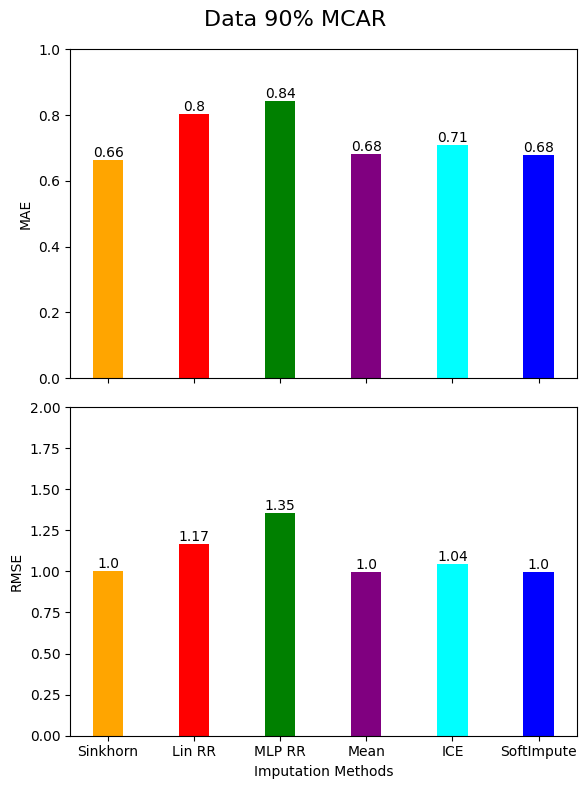

In [114]:

# Define values and categories
values_mae_mcar90 = [sk_mae_mcar90, lin_rr_mae_mcar90, mlp_rr_mae_mcar90, mean_mae_mcar90, ice_mae_mcar90, soft_mae_mcar90]
values_rmse_mcar90 = [sk_rmse_mcar90, lin_rr_rmse_mcar90, mlp_rr_rmse_mcar90, mean_rmse_mcar90, ice_rmse_mcar90, soft_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


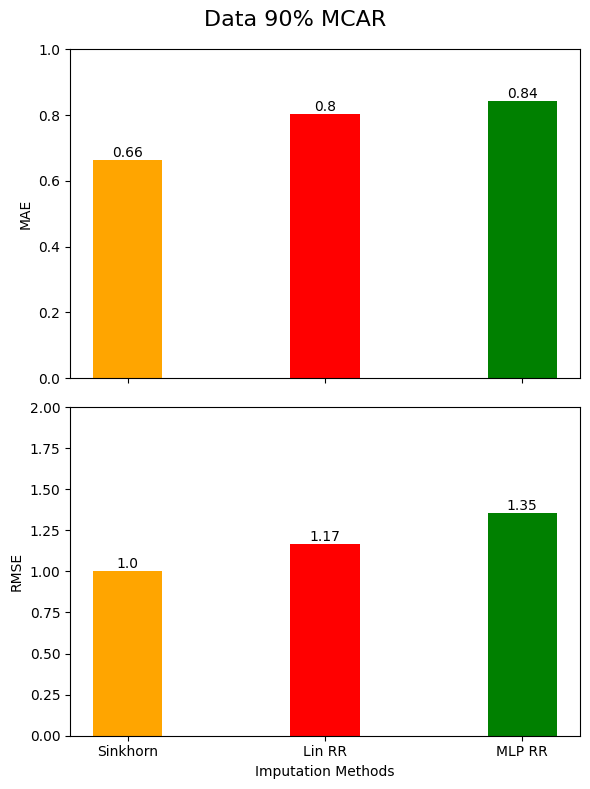

In [115]:

# Define values and categories
valuesOT_mae_mcar90 = [sk_mae_mcar90,lin_rr_mae_mcar90,mlp_rr_mae_mcar90]
valuesOT_rmse_mcar90 = [sk_rmse_mcar90,lin_rr_rmse_mcar90,mlp_rr_rmse_mcar90]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 90% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar90, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar90, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


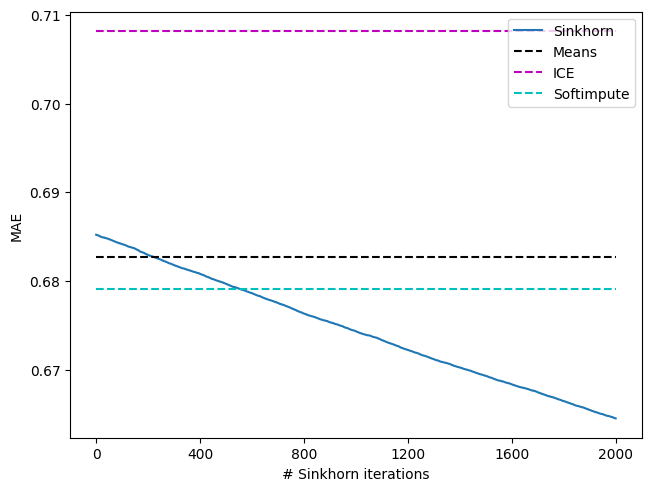

In [116]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

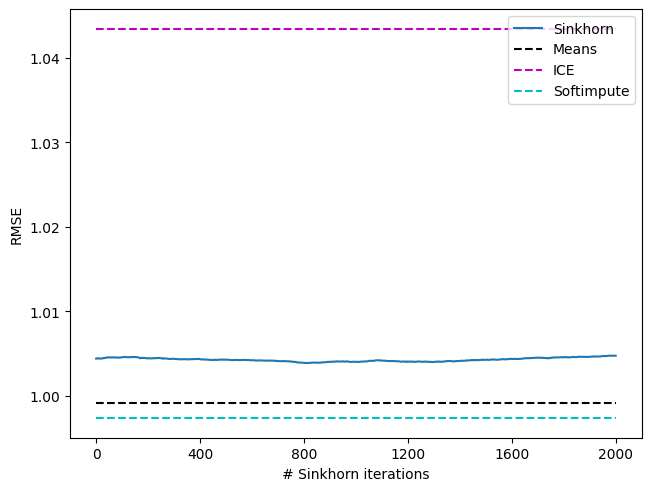

In [117]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses90mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses90mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar90, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar90, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar90, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

95% MCAR

In [118]:
#sinkhorn
n_mcar95, d_mcar95 = data_mcar95.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar95 = pick_epsilon(data_mcar95)

print(epsilon_mcar95)

sk_imputer_mcar95 = SinkhornImputation(eps=epsilon_mcar95, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar95, sk_maes95mcar, sk_rmses95mcar = sk_imputer_mcar95.fit_transform(data_mcar95, verbose=True, report_interval=500, X_true=ground_truth.clone())
#using numpy version of data
sk_imp_mcar95_numpy = sk_imp_mcar95.detach().cpu().numpy()

sk_mae_mcar95 = MAE(sk_imp_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
sk_rmse_mcar95 = RMSE(sk_imp_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(sk_mae_mcar95,sk_rmse_mcar95)

INFO:root:batchsize = 128, epsilon = 0.0136


0.013627242873847353


INFO:root:Iteration 0:	 Loss: 0.4084	 Validation MAE: 0.6848	RMSE: 1.0047
INFO:root:Iteration 500:	 Loss: 0.4651	 Validation MAE: 0.6825	RMSE: 1.0049
INFO:root:Iteration 1000:	 Loss: 0.2603	 Validation MAE: 0.6802	RMSE: 1.0049
INFO:root:Iteration 1500:	 Loss: 0.3823	 Validation MAE: 0.6781	RMSE: 1.0051


0.6761177644107947 1.0055292568281364


In [119]:
#linear Round Robin
dmcar95_ = d_mcar95 - 1
models_liner_mcar95 = {}

for i in range(d_mcar95):
    models_liner_mcar95[i] = nn.Linear(dmcar95_, 1)

#Create the imputer
lin_rr_imputer_mcar95 = RRimputer(models_liner_mcar95, eps=epsilon_mcar95, lr=lr)
lin_rr_mcar95, lin_maesmcar95, lin_rmsesmcar95 = lin_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)
lin_rr_mcar95_numpy = lin_rr_mcar95.detach().cpu().numpy()

lin_rr_mae_mcar95 = MAE(lin_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
lin_rr_rmse_mcar95 = RMSE(lin_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(lin_rr_mae_mcar95,lin_rr_rmse_mcar95)

INFO:root:Iteration 0:	 Loss: 1.2072	Validation MAE: 0.7113	RMSE:  1.0359
INFO:root:Iteration 1:	 Loss: 2.7249	Validation MAE: 0.7993	RMSE:  1.1613
INFO:root:Iteration 2:	 Loss: 2.0434	Validation MAE: 0.7980	RMSE:  1.1420
INFO:root:Iteration 3:	 Loss: 2.4643	Validation MAE: 0.8123	RMSE:  1.1634
INFO:root:Iteration 4:	 Loss: 3.1206	Validation MAE: 0.8242	RMSE:  1.1838
INFO:root:Iteration 5:	 Loss: 1.9436	Validation MAE: 0.8063	RMSE:  1.1588
INFO:root:Iteration 6:	 Loss: 2.3138	Validation MAE: 0.8164	RMSE:  1.1697
INFO:root:Iteration 7:	 Loss: 2.4907	Validation MAE: 0.8134	RMSE:  1.1633
INFO:root:Iteration 8:	 Loss: 2.9699	Validation MAE: 0.8156	RMSE:  1.1721
INFO:root:Iteration 9:	 Loss: 4.0023	Validation MAE: 0.8149	RMSE:  1.1679
INFO:root:Early stopping criterion not reached


0.8149275853926855 1.1678872040546089


In [120]:
#MLP Round Robin
dmcar95_ = d_mcar95 - 1
models_mlp_mcar95 = {}


for i in range(d_mcar95):
   models_mlp_mcar95[i] = nn.Sequential(nn.Linear(dmcar95_, 2 * dmcar95_),
                              nn.ReLU(),
                              nn.Linear(2 * dmcar95_, dmcar95_),
                              nn.ReLU(),
                              nn.Linear(dmcar95_, 1))

#Create the imputer
mlp_rr_imputer_mcar95 = RRimputer(models_mlp_mcar95, eps=epsilon_mcar95, lr=lr)

mlp_rr_mcar95, mlp_rr_maesmcar95, mlp_rr_rmsesmcar95 = mlp_rr_imputer_mcar95.fit_transform(data_mcar95, verbose=True, X_true=ground_truth)

mlp_rr_mcar95_numpy = mlp_rr_mcar95.detach().cpu().numpy()

mlp_rr_mae_mcar95 = MAE(mlp_rr_mcar95_numpy,ground_truth_numpy ,mask_mcar95)
mlp_rr_rmse_mcar95 = RMSE(mlp_rr_mcar95_numpy, ground_truth_numpy,mask_mcar95)
print(mlp_rr_mae_mcar95, mlp_rr_rmse_mcar95)

INFO:root:Iteration 0:	 Loss: 1.4005	Validation MAE: 0.7733	RMSE:  1.1302
INFO:root:Iteration 1:	 Loss: 1.9845	Validation MAE: 0.8473	RMSE:  1.2668
INFO:root:Iteration 2:	 Loss: 2.9054	Validation MAE: 0.8505	RMSE:  1.3368
INFO:root:Iteration 3:	 Loss: 1.9768	Validation MAE: 0.8255	RMSE:  1.3083
INFO:root:Iteration 4:	 Loss: 7.4999	Validation MAE: 0.8275	RMSE:  1.3331
INFO:root:Iteration 5:	 Loss: 2.4550	Validation MAE: 0.8255	RMSE:  1.3248
INFO:root:Iteration 6:	 Loss: 1.3007	Validation MAE: 0.8314	RMSE:  1.3529
INFO:root:Iteration 7:	 Loss: 1.9750	Validation MAE: 0.8299	RMSE:  1.3425
INFO:root:Iteration 8:	 Loss: 1.6035	Validation MAE: 0.8298	RMSE:  1.3501
INFO:root:Iteration 9:	 Loss: 2.3269	Validation MAE: 0.8312	RMSE:  1.3475
INFO:root:Early stopping criterion not reached


0.8311506680379516 1.3475260423531552


In [121]:
#mean
#using numpy version of data
mean_imp_mcar95 = SimpleImputer().fit_transform(data_mcar95_numpy)
mean_mae_mcar95 = MAE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
mean_rmse_mcar95 = RMSE(mean_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(mean_mae_mcar95, mean_rmse_mcar95)

#ICE
ice_imp_mcar95 = IterativeImputer(random_state=0, max_iter=500).fit_transform(data_mcar95_numpy)
ice_mae_mcar95 = MAE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
ice_rmse_mcar95 = RMSE(ice_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(ice_mae_mcar95,ice_rmse_mcar95)

#SoftImpute
cv_error_mcar95, grid_lambda_mcar95 = cv_softimpute(data_mcar95_numpy, grid_len=15)
lbda_mcar95 = grid_lambda_mcar95[np.argmin(cv_error_mcar95)]
soft_imp_mcar95 = softimpute((data_mcar95_numpy), lbda_mcar95)[1]

soft_mae_mcar95 = MAE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
soft_rmse_mcar95 = RMSE(soft_imp_mcar95, ground_truth_numpy, mask_mcar95)
print(soft_mae_mcar95,soft_rmse_mcar95)

0.682588320694853 0.9998004416437197
0.6973565559515922 1.0326665370981714
0.6810898752428114 0.9994727344873701


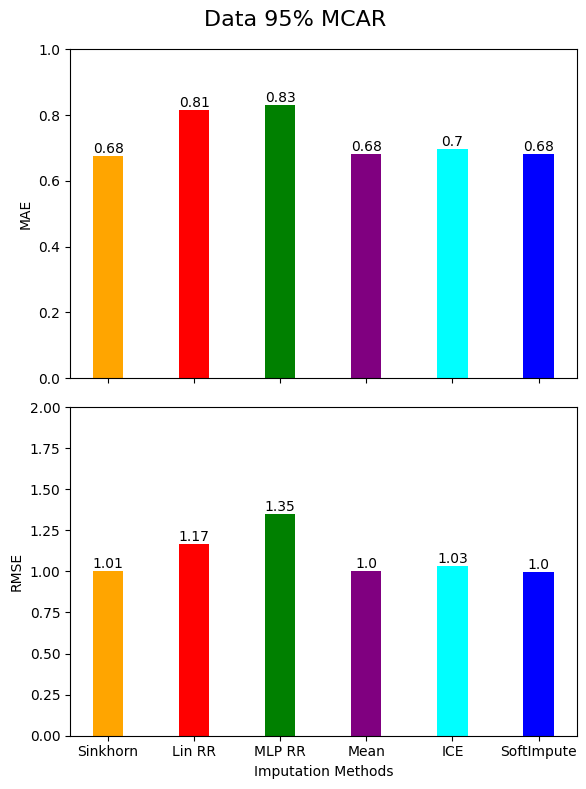

In [122]:

# Define values and categories
values_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95, mean_mae_mcar95, ice_mae_mcar95, soft_mae_mcar95]
values_rmse_mcar95 = [sk_rmse_mcar95, lin_rr_rmse_mcar95, mlp_rr_rmse_mcar95, mean_rmse_mcar95, ice_rmse_mcar95, soft_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR','Mean', 'ICE', 'SoftImpute']
colors = ['orange','red','green', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


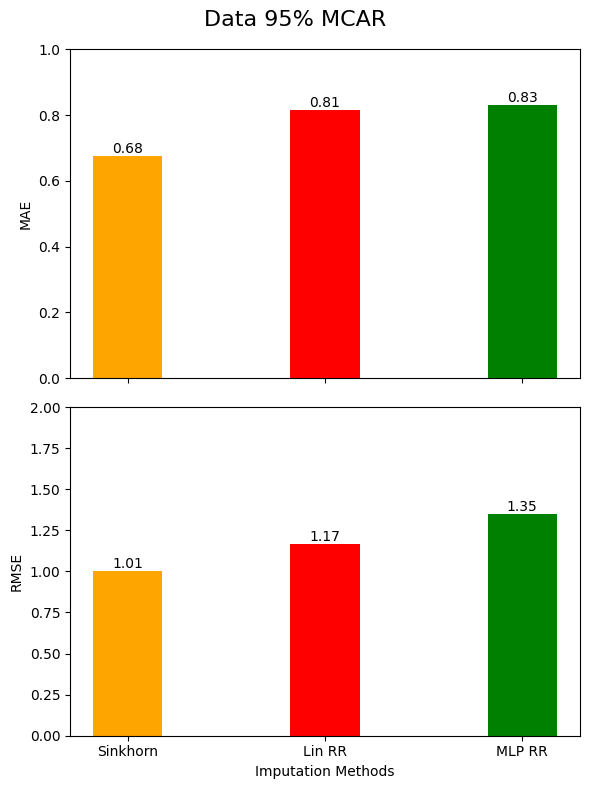

In [123]:

# Define values and categories
valuesOT_mae_mcar95 = [sk_mae_mcar95,lin_rr_mae_mcar95,mlp_rr_mae_mcar95]
valuesOT_rmse_mcar95 = [sk_rmse_mcar95,lin_rr_rmse_mcar95,mlp_rr_rmse_mcar95]
categories = ['Sinkhorn','Lin RR','MLP RR']
colors = ['orange','red','green']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 95% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, valuesOT_mae_mcar95, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, valuesOT_rmse_mcar95, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


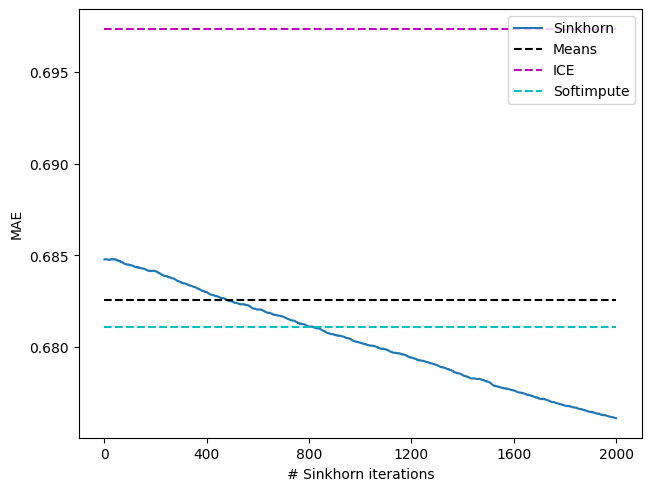

In [124]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

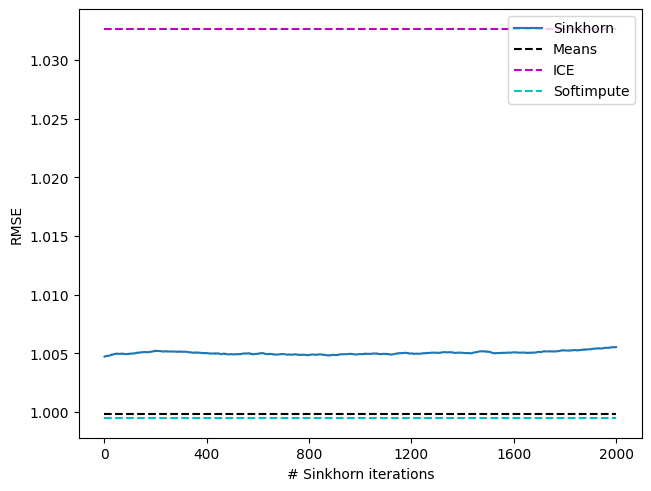

In [125]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses95mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses95mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar95, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar95, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar95, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()

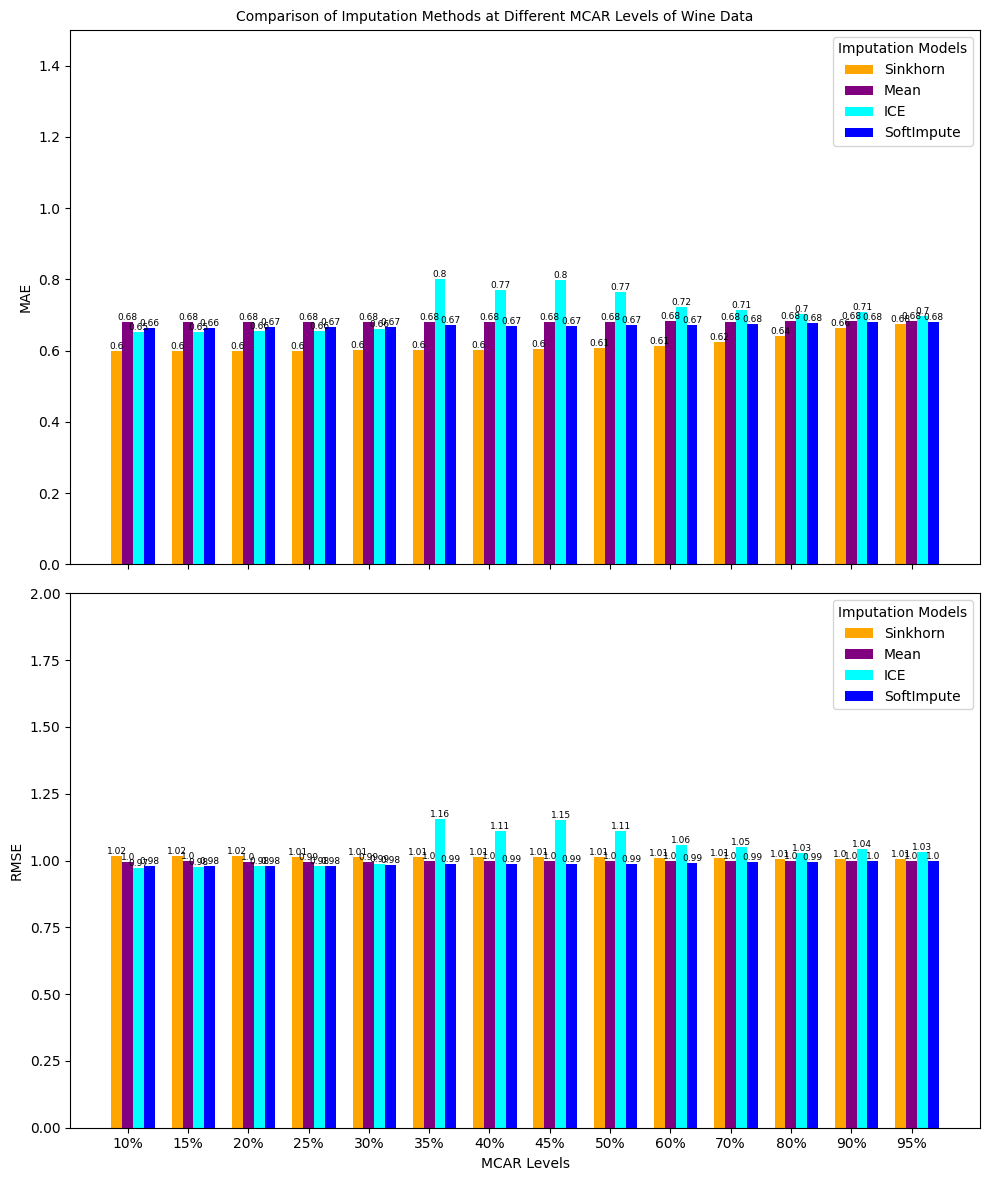

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30,sk_mae_mcar35,sk_mae_mcar40,sk_mae_mcar45,sk_mae_mcar50,sk_mae_mcar60,sk_mae_mcar70,sk_mae_mcar80,sk_mae_mcar90,sk_mae_mcar95]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30,mean_mae_mcar35,mean_mae_mcar40,mean_mae_mcar45,mean_mae_mcar50,mean_mae_mcar60,mean_mae_mcar70,mean_mae_mcar80,mean_mae_mcar90,mean_mae_mcar95]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30,ice_mae_mcar35,ice_mae_mcar40,ice_mae_mcar45,ice_mae_mcar50,ice_mae_mcar60,ice_mae_mcar70,ice_mae_mcar80,ice_mae_mcar90,ice_mae_mcar95]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30,soft_mae_mcar35,soft_mae_mcar40,soft_mae_mcar45,soft_mae_mcar50,soft_mae_mcar60,soft_mae_mcar70,soft_mae_mcar80,soft_mae_mcar90,soft_mae_mcar95]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30,sk_rmse_mcar35,sk_rmse_mcar40,sk_rmse_mcar45,sk_rmse_mcar50,sk_rmse_mcar60,sk_rmse_mcar70,sk_rmse_mcar80,sk_rmse_mcar90,sk_rmse_mcar95]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30,mean_rmse_mcar35,mean_rmse_mcar40,mean_rmse_mcar45,mean_rmse_mcar50,mean_rmse_mcar60,mean_rmse_mcar70,mean_rmse_mcar80,mean_rmse_mcar90,mean_rmse_mcar95]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30,ice_rmse_mcar35,ice_rmse_mcar40,ice_rmse_mcar45,ice_rmse_mcar50,ice_rmse_mcar60,ice_rmse_mcar70,ice_rmse_mcar80,ice_rmse_mcar90,ice_rmse_mcar95]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30,soft_rmse_mcar35,soft_rmse_mcar40,soft_rmse_mcar45,soft_rmse_mcar50,soft_rmse_mcar60,soft_rmse_mcar70,soft_rmse_mcar80,soft_rmse_mcar90,soft_rmse_mcar95]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10%', '15%', '20%', '25%', '30%','35%','40%','45%','50%','60%','70%','80%','90%','95%']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.18  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of Wine Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=6.5)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()
